In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt


## Strategy 1
Variation 1 : Ichimoku Strategy\
Variation 2: Ichimoku Strategy + Money Flow Index\
Due to the lack of package that supports Ichimoku Cloud strategy and Money Flow Index, our group has coded out the relevant technical indicators below.

In [ ]:
class MFI:
    def __init__(self,df, period = 14, high = 70, low = 30):
        self.df = df
        self.period = period
        self.high = high
        self.low = low

    def generate_MFI(self):
        typical_price = (self.df['Close'] + self.df['High'] + self.df['Low']) / 3

        # Calculate the money flow
        money_flow = typical_price * self.df['Volume']
        positive_flow = []
        negative_flow = []

        # Loop through the typical price
        for i in range(1, len(typical_price)):
            if typical_price[i] > typical_price[i-1]:
                positive_flow.append(money_flow[i-1])
                negative_flow.append(0)

            elif typical_price[i] < typical_price[i-1]:
                negative_flow.append( money_flow[i-1])
                positive_flow.append(0)

            else:
                positive_flow.append(0)
                negative_flow.append(0)
        positive_mf = []
        negative_mf = []

        for i in range(self.period-1, len(positive_flow)):
            positive_mf.append( sum(positive_flow[i + 1- self.period : i+1]))

        for i in range(self.period-1, len(negative_flow)):
            negative_mf.append( sum(negative_flow[i + 1- self.period : i+1]))
        mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
        # to resolve the missing rows due to the indicator
        extra = [np.nan for i in range(self.period)]
        extra.extend(mfi)
        self.df['MFI'] = extra

    # overbought if MFI > high, so take a short position
    # oversold if MFI < low, so take a long position
    def __generate_overbought_or_oversold(self, row):
        if row["MFI"] >= self.high:
            return -1
        elif row["MFI"] <= self.low:
            return 1
        else:
            return 0

    # generate signal columns
    def __generate_signal(self):
        self.df["MFI signal"] = self.df.apply(self.__generate_overbought_or_oversold, axis = 1)


    def generate_trading_signal(self):
        self.__generate_signal()

    def get_df(self):
      return self.df



In [ ]:
class IchimokuCloud:
    def __init__(self, stock_df, cl_period = 9, bl_period = 26, look_forward_a = 26 , lead_span_b_period = 52 , look_forward_b = 26, chikou_span_period = 26, lag_span_period = 26):
        self.cl_period = cl_period
        self.bl_period = bl_period
        self.look_forward_a = look_forward_a
        self.look_forward_b = look_forward_b
        self.lead_span_b_period = lead_span_b_period
        self.chikou_span_period = chikou_span_period
        self.lag_span_period = lag_span_period
        self.df = stock_df

    # return df with all the indicators as columns
    def generate_conversion_line(self):
        period_high = self.df['High'].rolling(self.cl_period).max()
        period_low = self.df["Low"].rolling(self.cl_period).min()
        self.df['conversion_line'] = (period_high + period_low) / 2

    def generate_base_line(self):
        period_high = self.df['High'].rolling(self.bl_period).max()
        period_low = self.df["Low"].rolling(self.bl_period).min()
        self.df['base_line'] = (period_high + period_low) / 2

    def generate_lead_span_a_line(self):
        self.df['lead_span_a'] = ((self.df["conversion_line"] + self.df['base_line'])/2).shift(self.look_forward_a)

    def generate_lead_span_b_line(self):
        period_high = self.df['High'].rolling(self.lead_span_b_period).max()
        period_low = self.df['Low'].rolling(self.lead_span_b_period).min()
        # print(period_high[50:])
        self.df['lead_span_b'] = ((period_high + period_low)/2).shift(self.look_forward_b)

    def generate_lagging_span(self):
        self.df['lagging_span'] = self.df['Close'].shift(-self.lag_span_period)

    # generate all indicators
    def generate_lines(self):
        self.generate_conversion_line()
        self.generate_base_line()
        self.generate_lead_span_a_line()
        self.generate_lead_span_b_line()
        self.generate_lagging_span()

    def drop_na(self):
        self.df = self.df.dropna()


    # if lead span a > lead span b this indicates a bullish trend
    # if lead span a < lead span b this indicates a bearish trend
    def __generate_trend_signal_row(self,row):
        if row['lead_span_a'] >= row['lead_span_b']:
            return 1

        elif row['lead_span_a'] <= row['lead_span_b']:
            return -1
        else:
            return 0

    # generate the trend signal column
    def __generate_trend_signal(self):
        self.df["trend_signal"] = self.df.apply(self.__generate_trend_signal_row, axis=1)

    # generate position based on the rule
    # 5 different values position can take
    # if indicator highly indicates a bullish trend, then return the value 2
    # if indicator indicates a bullish trend, then return the value 1
    # if indicator highly indicates a bearish trend, then return the value -2
    # if indicator indicates a bearish trend, then return the value -1
    # else return 0

    def __generate_signals(self, row):
        cloud_value = None
        if row['trend_signal'] == 1:
            cloud_value = row["lead_span_a"]
        else:
            cloud_value = row["lead_span_b"]
        if (row['trend_signal'] == 1)  and (row["Close"] > cloud_value):
            return 2
        elif (row['trend_signal'] == -1) and (row["Close"] < cloud_value) :
            return -2
        elif (row['trend_signal'] == 1):
            return 1
        elif (row['trend_signal'] == -1):
            return -1
        else: return 0

    # A long position is determined if the signal is 2 and the signal is greater than the previous signal
    # A sell position is determined if the signal is -2 and the signal is lesser than the previous signal
    # if indicator is not ready, we will return 0
    # if signal is uncertain, we will give a nan value which will be filled later with the previous position
    def __generate_ichimoku_position(self,row):
        if (pd.isna(row['lead_span_b'])):
          return 0
        if (row["signal"] < row["previous signal"]) and (row["signal"] == -2):
            return -1
        elif (row["signal"] > row["previous signal"]) and (row["signal"] == 2):
          return 1
        else:
            return np.nan


    # generate position
    def generate_trading_position(self):
        self.__generate_trend_signal()
        self.df["signal"] = self.df.apply(self.__generate_signals, axis=1)
        self.df["previous signal"] = self.df["signal"].shift()
        self.df['position'] = self.df.apply(self.__generate_ichimoku_position, axis = 1)
        # to resolve look ahead bias
        self.df["position"] = self.df["position"].shift()

    def get_df(self):
      return self.df

    def __repr__(self):
        return f"Ichimoku Cloud"







## Variation 1 Ichimoku Strategy
Ichimoku Cloud is a technical indicator that comprises several components to generate trading signals. The components are Conversion Line, Base Line, Lead Span A, Lead Span B and Lagging Span. The area between leading span A and leading Span B forms the cloud. The cloud is red if leading span A is below leading span B and it is green if leading span A is above leading span B. \
Trading Rule:

1) We will buy if the leading span A crosses over leading span B and the price crosses above the Ichimoku Cloud. The value of this cloud will be leading span A’s value if it is an uptrend.

2) We will sell if the leading span A crosses below leading span B and the price crosses below the Ichimoku Cloud. The value of this cloud will be the leading span B’s value if it is a downtrend.



In [ ]:
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]

start = "2015-01-01"
end = "2019-12-31"

In [ ]:
# generate buy / sell signal
def generate_trading_signal_ichimoku(row):
  if ((row["Final Position"] > row["Previous Final Position"])):
    return 1
  elif ((row["Final Position"] < row["Previous Final Position"])):
    return -1
  else:
    return 0

In [ ]:
# passing in the stock dataframe into the ichimikou cloud strategy
stocks_df = []
stocks_df_with_indicators = []
for stock in stock_list:
  data = yf.download(stock, start=start, end=end)
  stocks_df.append(data)
for stock_df in stocks_df:
  stock_ichimoku = IchimokuCloud(stock_df=stock_df)
  stock_ichimoku.generate_lines()
  stock_ichimoku.generate_trading_position()
  df = stock_ichimoku.get_df()
  df = df.rename(columns = {"position" : "Final Position"})
  # this is to fill uncertain position with previous position
  df["Final Position"] = df["Final Position"].fillna(method = "ffill").shift()
  df["Previous Final Position"] = df["Final Position"].shift()
  df["Final Trading Signal"] = df.apply(generate_trading_signal_ichimoku, axis = 1)
  stocks_df_with_indicators.append(df)





[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


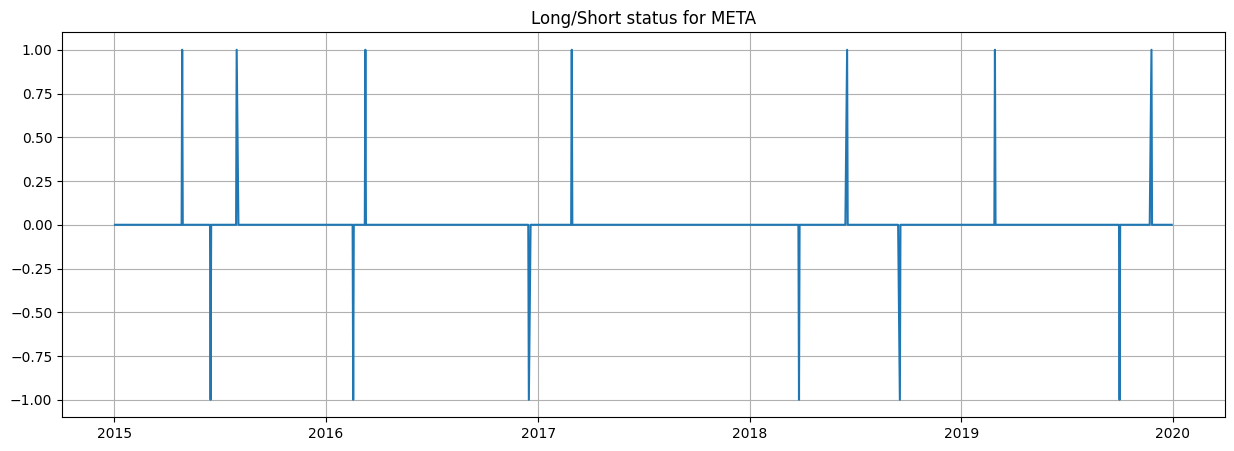

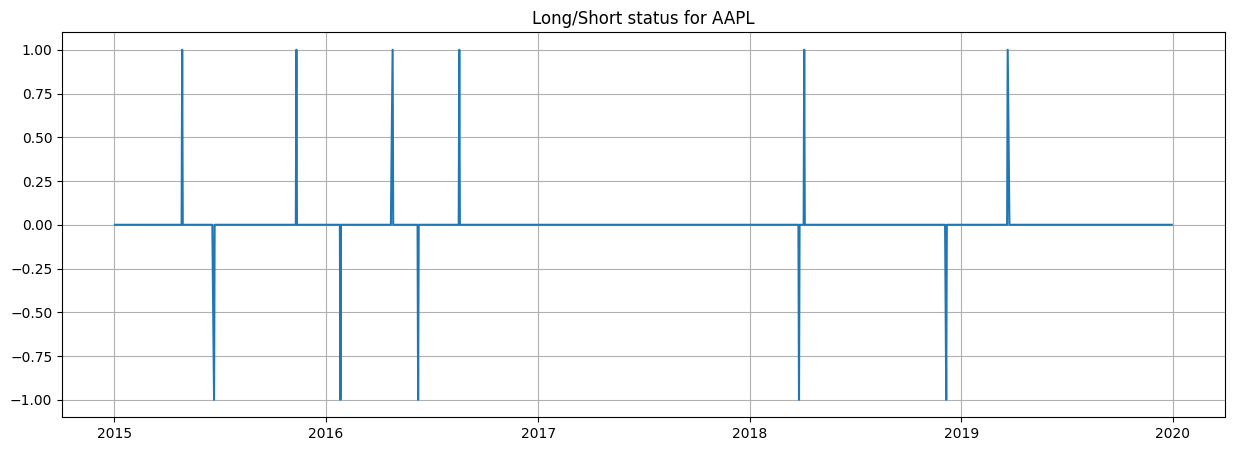

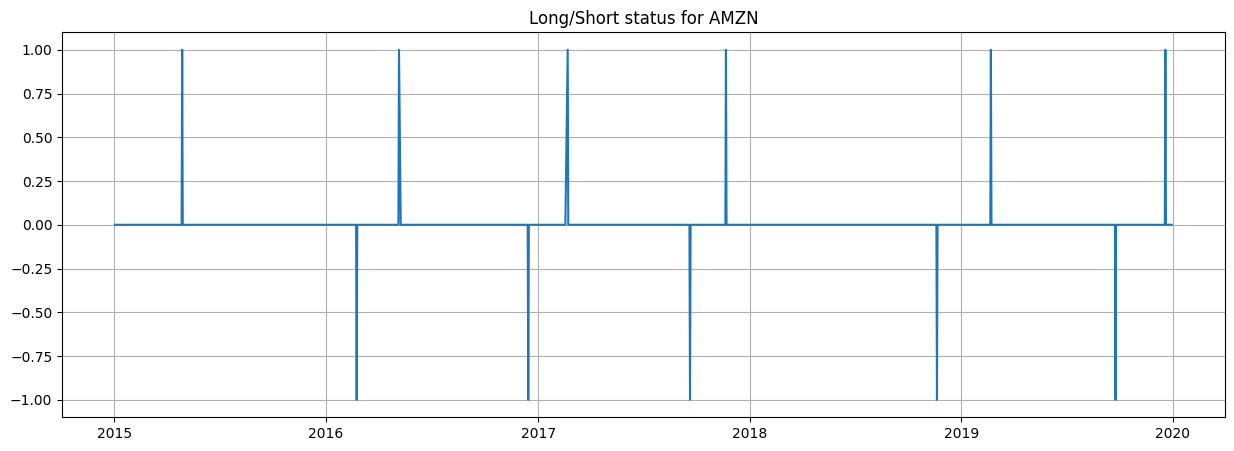

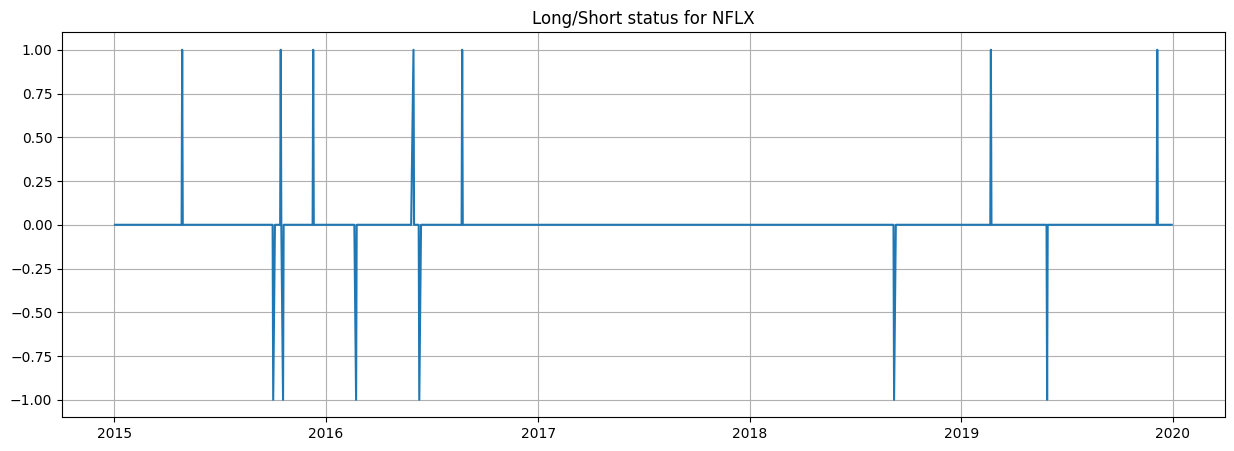

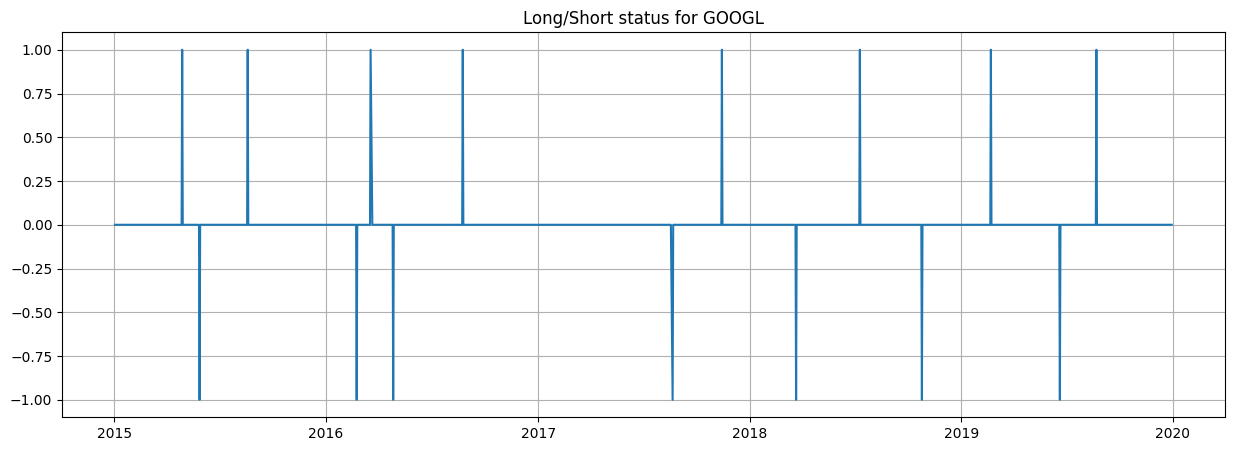

In [ ]:
# to get long short status
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
stock_name_and_df = list(zip(stock_list, stocks_df_with_indicators))
for stock_name, s  in stock_name_and_df:
  plt.figure(figsize=(15,5))
  plt.plot(s["Final Trading Signal"])
  plt.title(f"Long/Short status for {stock_name}")
  plt.grid()
  plt.show()

In [ ]:
# calculation of returns
for df in stocks_df_with_indicators:
  df["Stock Returns"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
  df["Stock Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
  df["Strategy Returns"] = df["Stock Returns"] * df["Final Position"]
  df["Strategy Log Returns"] = df["Stock Log Returns"] * df["Final Position"]


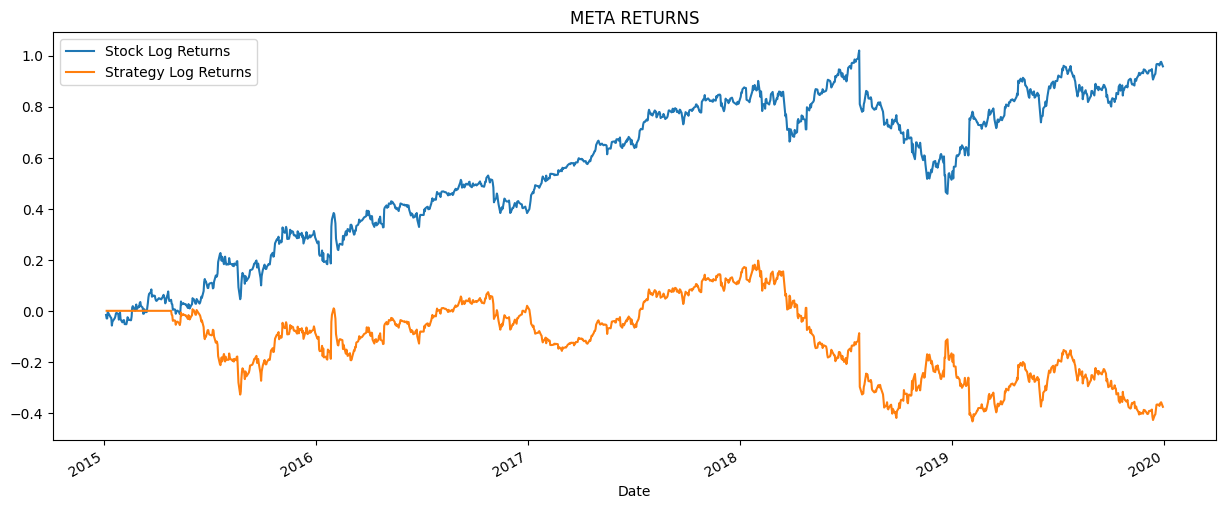

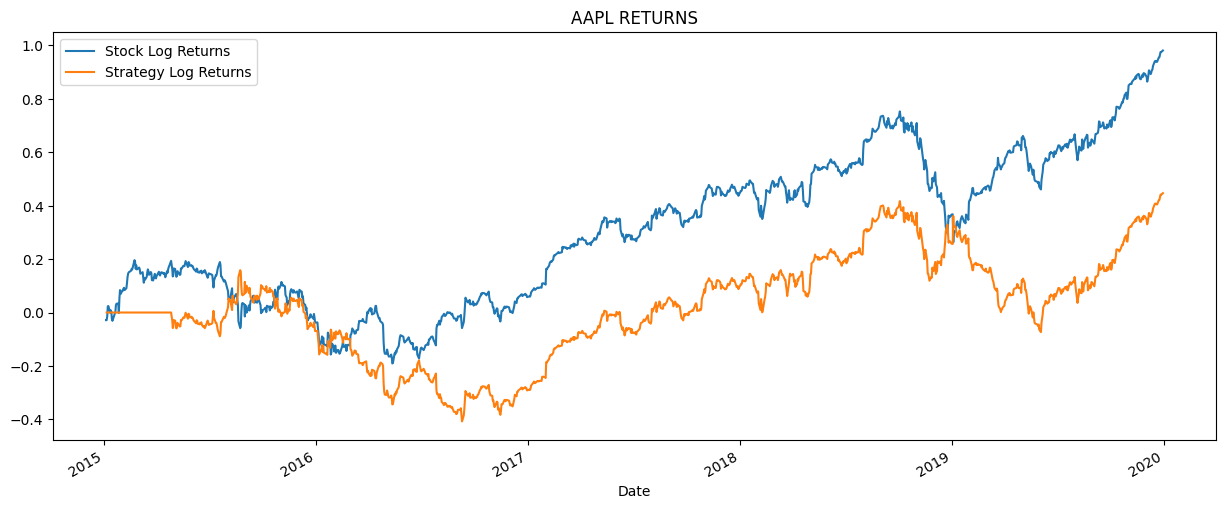

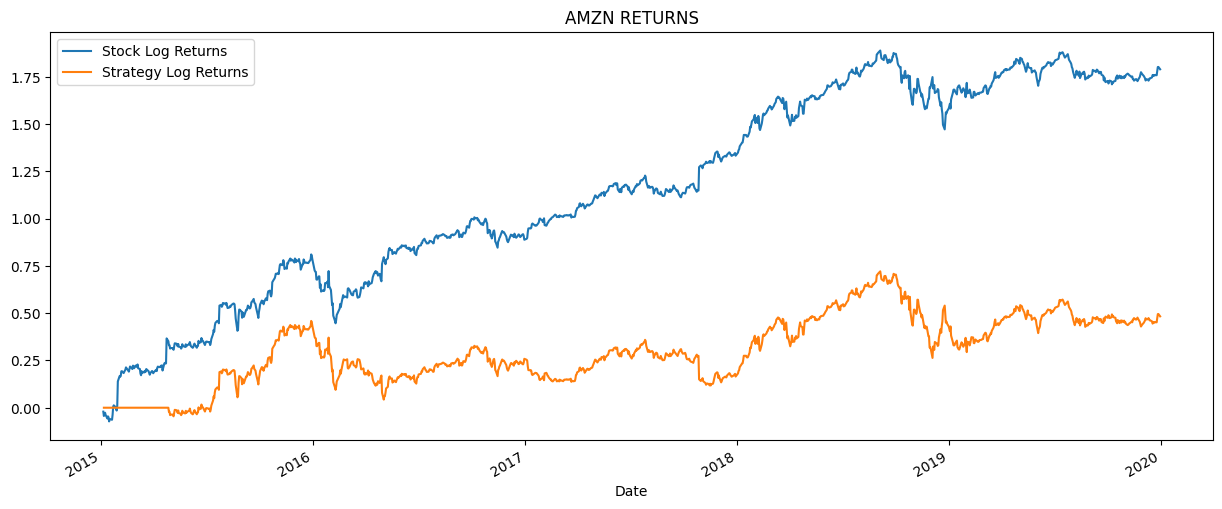

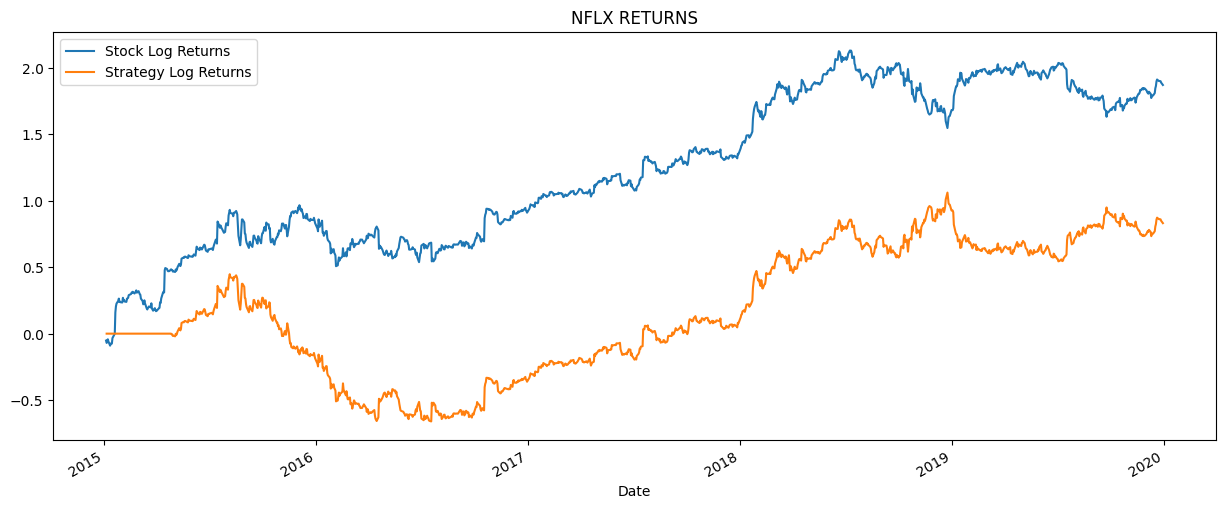

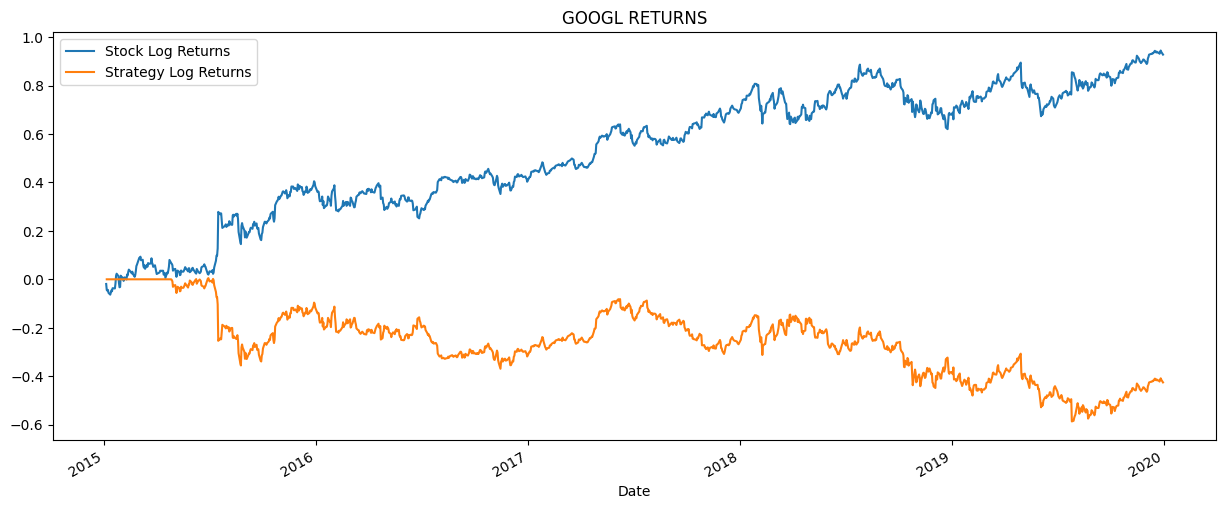

In [ ]:
# plotting of returns
for stock_name, df in stock_name_and_df:
  df[["Stock Log Returns", "Strategy Log Returns"]].cumsum().plot(figsize=(15,6), title = f"{stock_name} RETURNS")


In [ ]:
for stock_name, df in stock_name_and_df:
  final_stock_return = (df["Stock Log Returns"].sum())
  final_strategy_return = (df["Strategy Log Returns"].sum())
  print(f"{stock_name} final_stock_return {final_stock_return}")
  print(f"{stock_name} final_strategy_return {final_strategy_return} \n")


META final_stock_return 0.9576663584490293
META final_strategy_return -0.37604360938592185 

AAPL final_stock_return 0.9807377281908798
AAPL final_strategy_return 0.4467872995926146 

AMZN final_stock_return 1.78947174945224
AMZN final_strategy_return 0.4831330632868587 

NFLX final_stock_return 1.8696217621324844
NFLX final_strategy_return 0.8308574955270038 

GOOGL final_stock_return 0.9281807758088632
GOOGL final_strategy_return -0.4257918536443694 



In [ ]:
meta = stocks_df_with_indicators[0]
aapl = stocks_df_with_indicators[1]
amzn = stocks_df_with_indicators[2]
nflx = stocks_df_with_indicators[3]
googl = stocks_df_with_indicators[4]
portfolio_returns = (meta["Strategy Returns"] + aapl["Strategy Returns"] + amzn["Strategy Returns"] + nflx["Strategy Returns"] + googl["Strategy Returns"]) / 5
ichimoku_portfolio_only_returns = portfolio_returns
# R = log (R +1)
portfolio_returns.apply(np.log1p).sum()

0.1738728549244946

<Axes: title={'center': 'Portfolio Returns (Ichimoku)'}, xlabel='Date'>

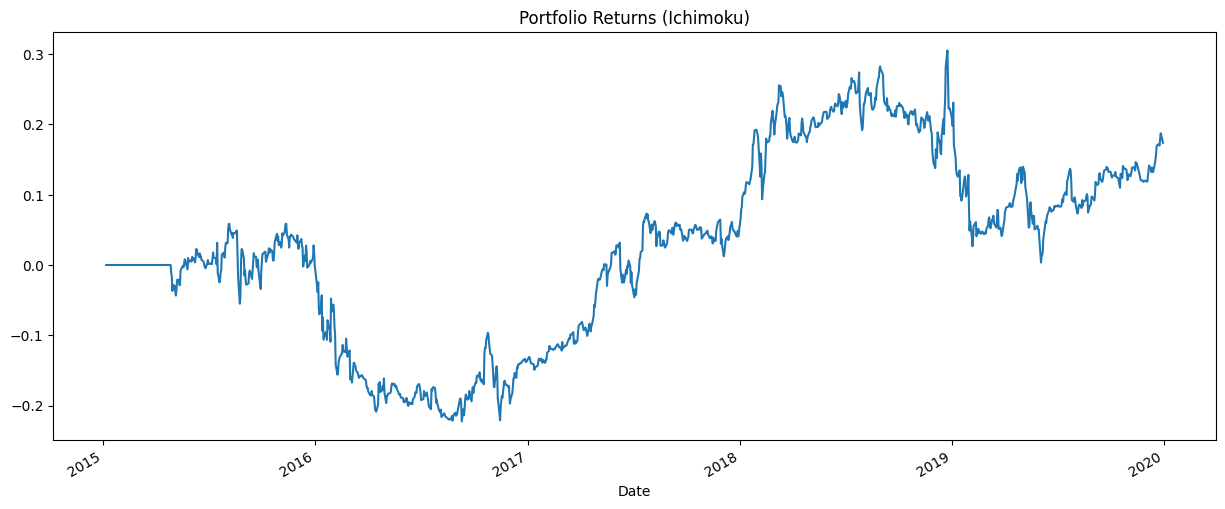

In [ ]:
portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (Ichimoku)")

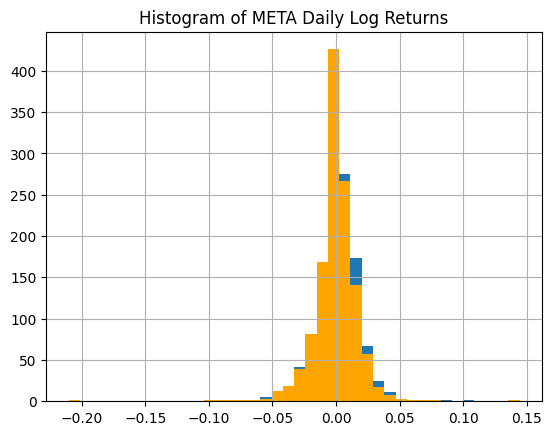

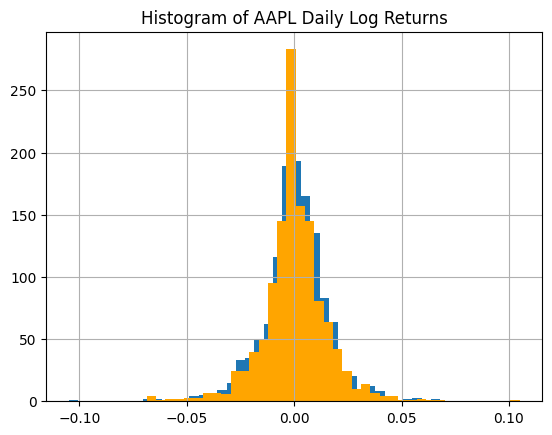

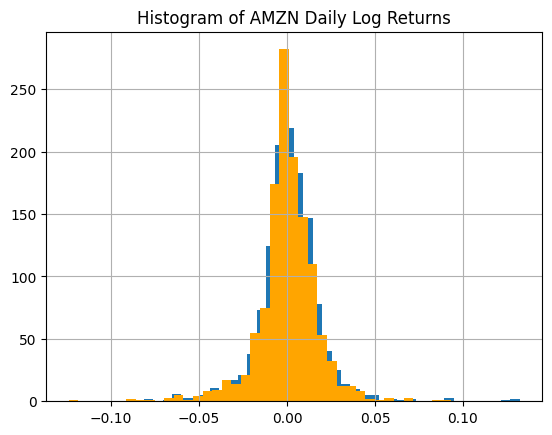

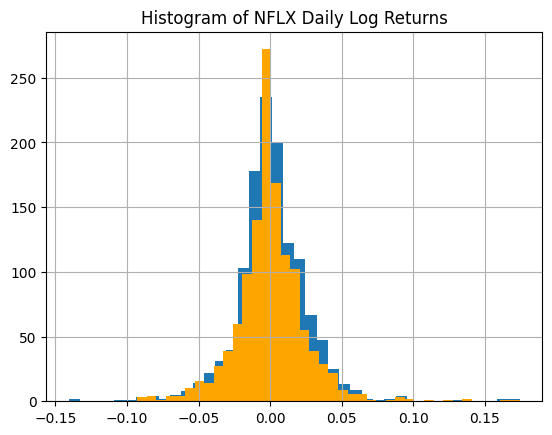

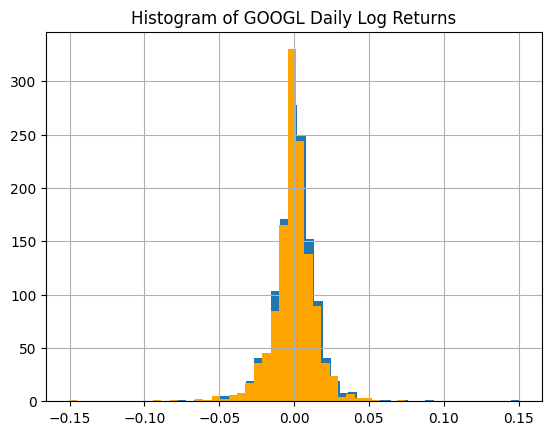

In [ ]:
# histogram of returns
for stock_name, df in stock_name_and_df:
  plt.hist(df["Stock Log Returns"], bins = 40)
  plt.hist(df["Strategy Log Returns"], bins = 40, color = "Orange")
  plt.title(f"Histogram of {stock_name} Daily Log Returns")
  plt.grid()
  plt.show()

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
start = "2015-01-01"
end = "2019-12-31"
for stock_name, df in stock_name_and_df:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")

Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns   -0.072728
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.276360
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns   -0.263164
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.217467
Strategy Log Returns    0.093861
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248711
Strategy Log Returns    0.241475
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.874375
Strategy Log Returns    0.388697
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns    0.101873
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.272174
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

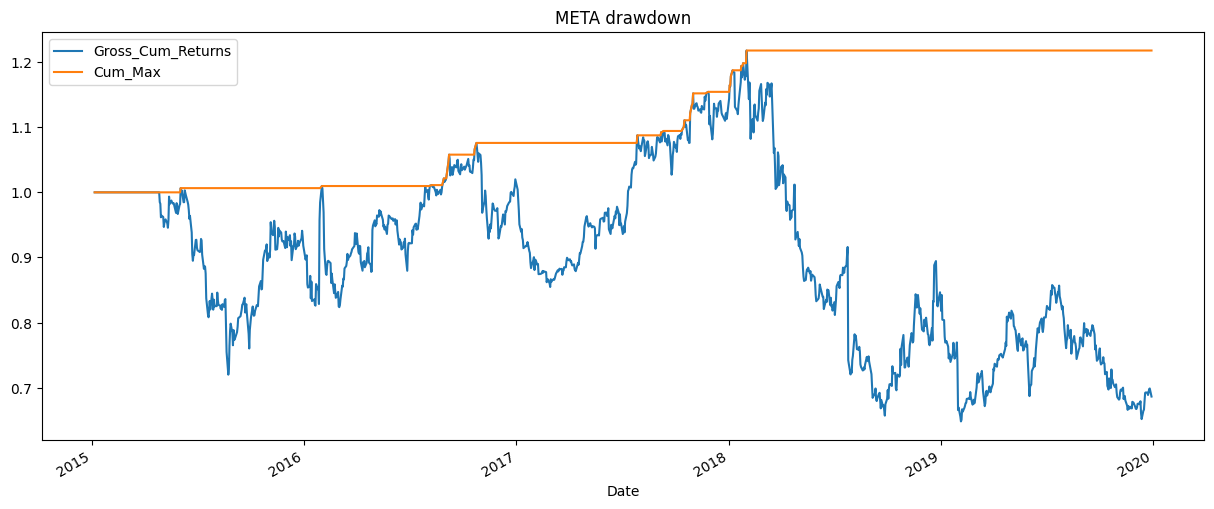

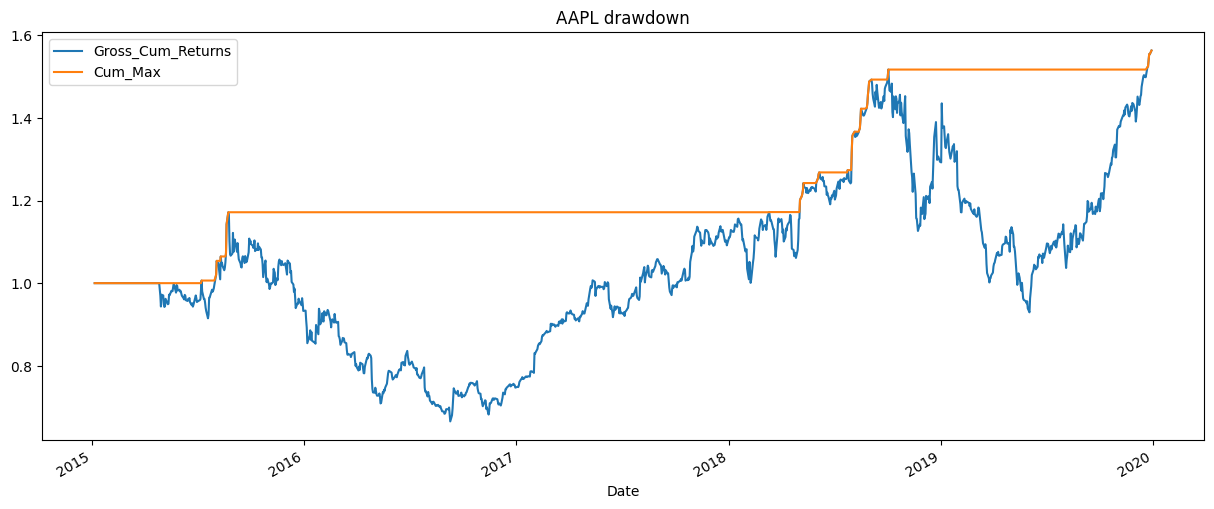

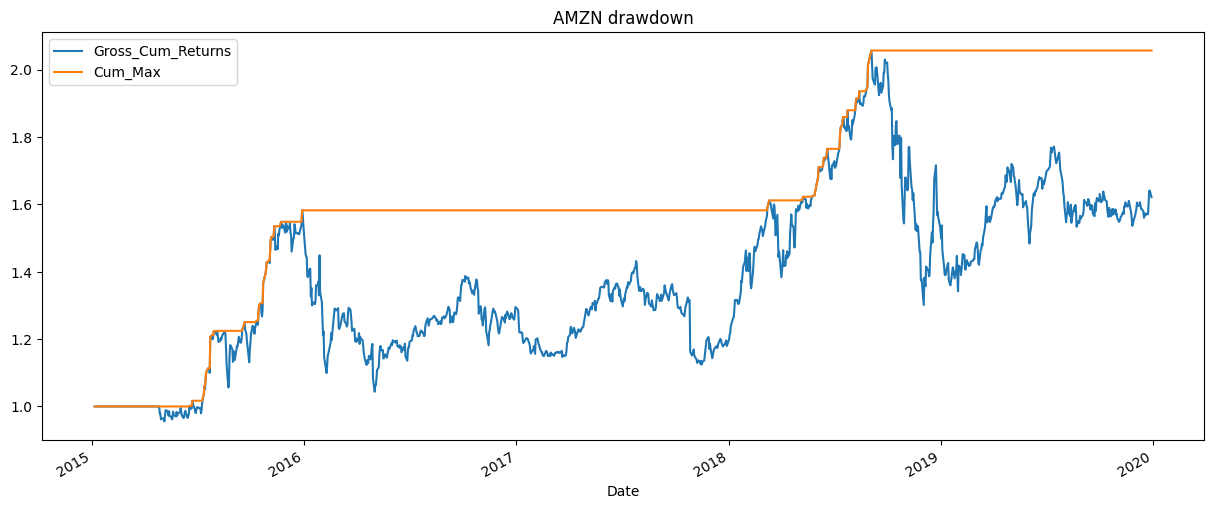

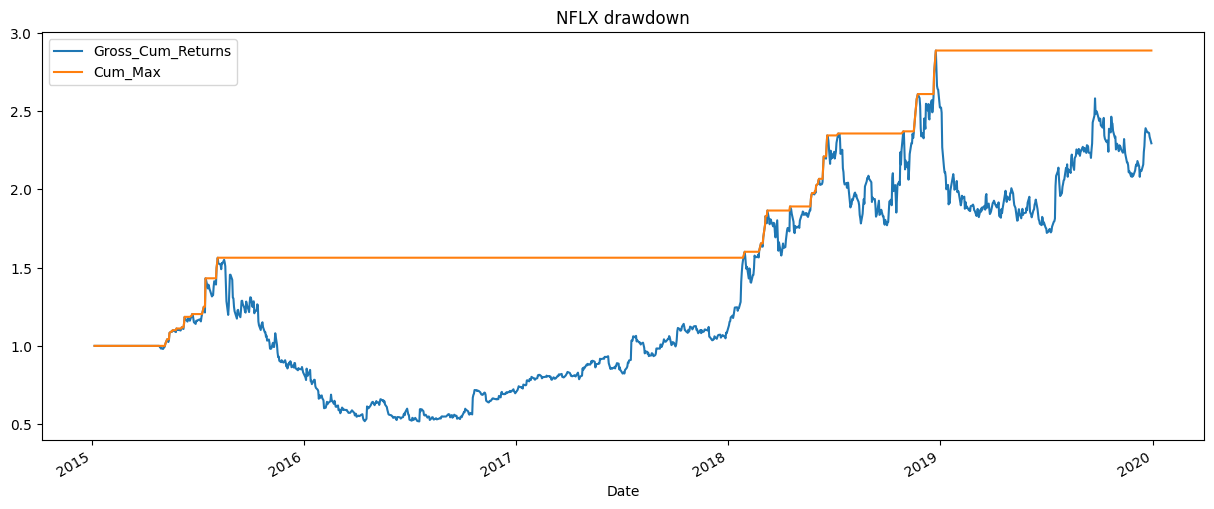

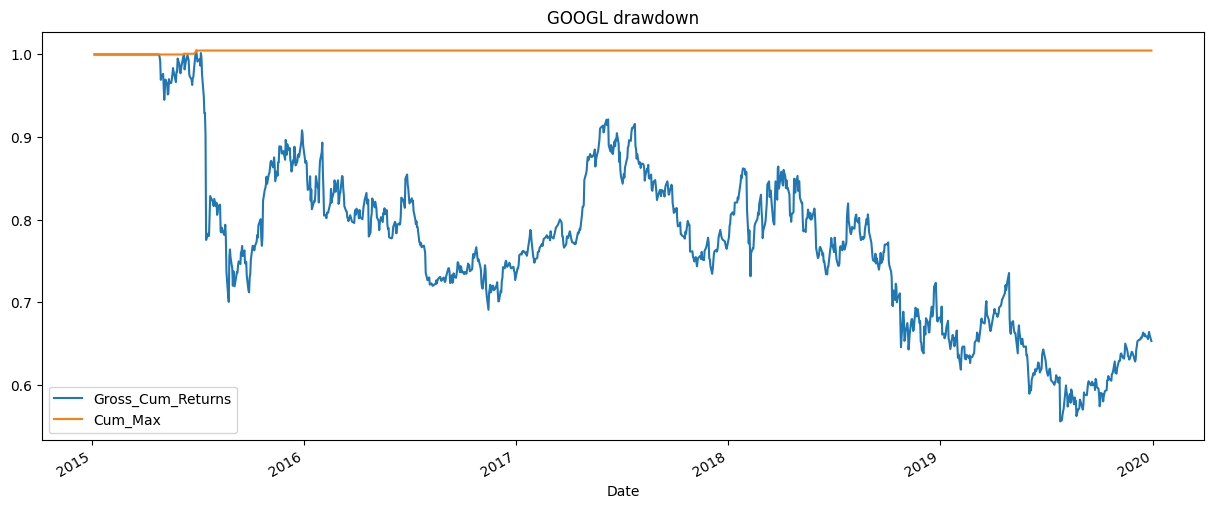

In [ ]:
for stock_name, df in stock_name_and_df:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()
  df[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6), title = f"{stock_name} drawdown")

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()


  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]

  zero_periods

In [ ]:
for stock_name, df in stock_name_and_df:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()
  print(f"{stock_name} max drawdown {max_drawdown}")

  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]
  print(f"{stock_name} zero periods {zero_periods}")

META max drawdown 0.5692943042763433
META zero periods Date
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
2015-01-12    0.0
             ... 
2018-01-05    0.0
2018-01-08    0.0
2018-01-23    0.0
2018-01-26    0.0
2018-02-01    0.0
Length: 104, dtype: float64
AAPL max drawdown 0.5878443596065798
AAPL zero periods Date
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
2015-01-12    0.0
             ... 
2018-10-03    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-26    0.0
2019-12-30    0.0
Length: 115, dtype: float64
AMZN max drawdown 0.7554472074198859
AMZN zero periods Date
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
2015-01-12    0.0
             ... 
2018-08-28    0.0
2018-08-29    0.0
2018-08-30    0.0
2018-08-31    0.0
2018-09-04    0.0
Length: 142, dtype: float64
NFLX max drawdown 1.1660848264429182
NFLX zero periods Date
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
2015-01-12

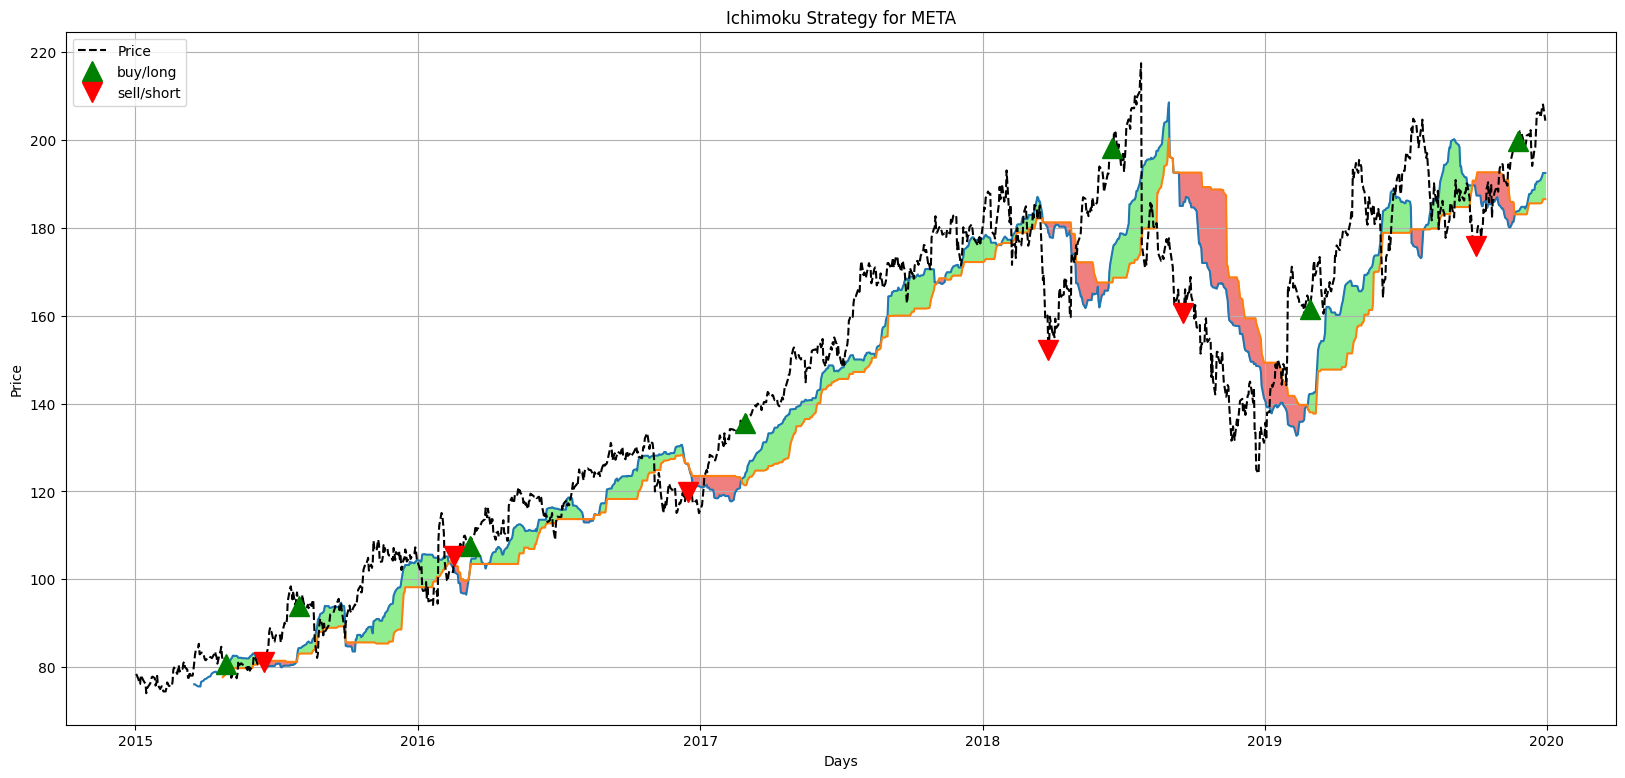

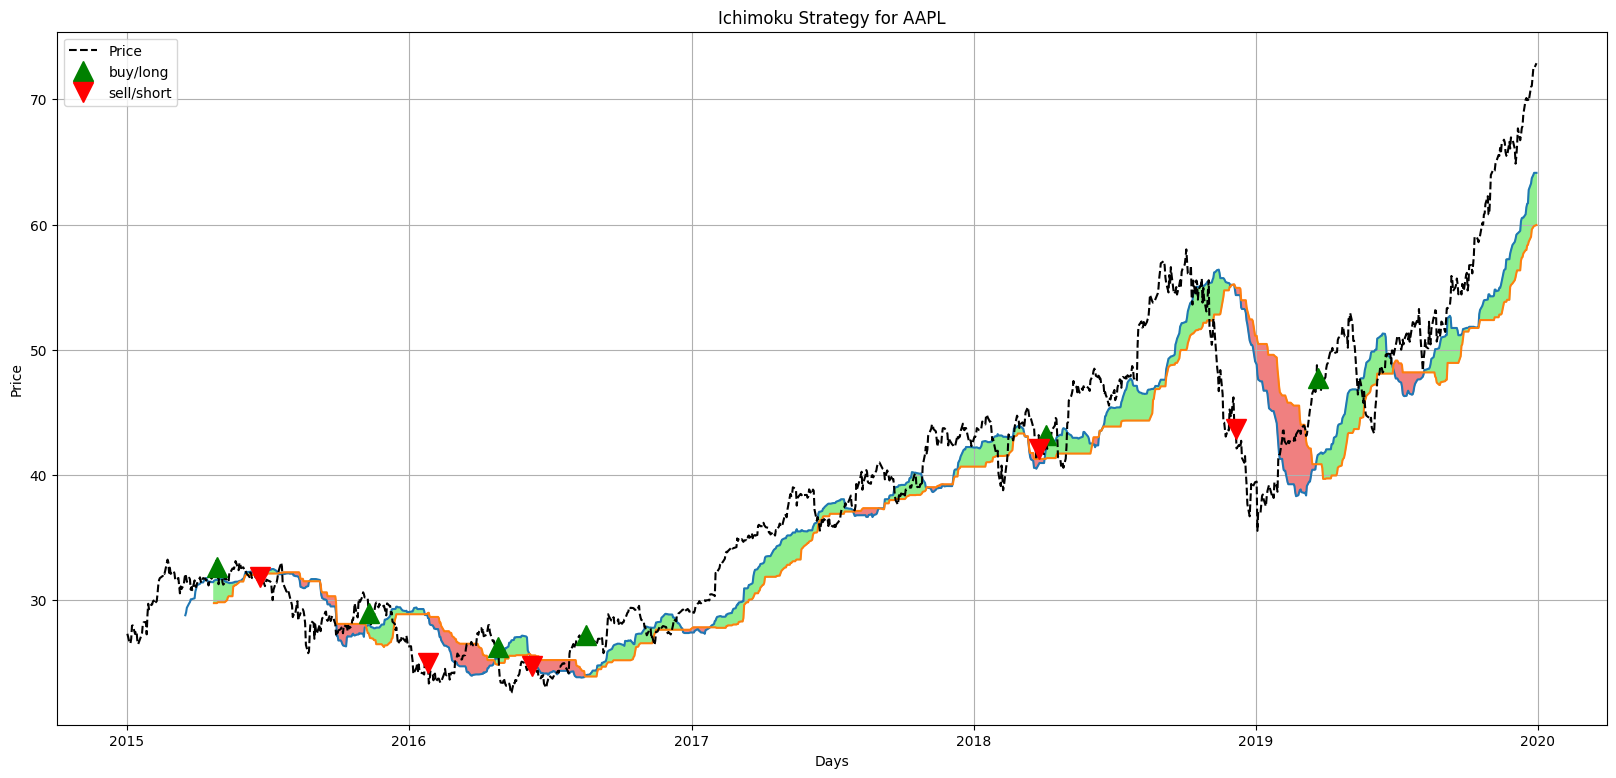

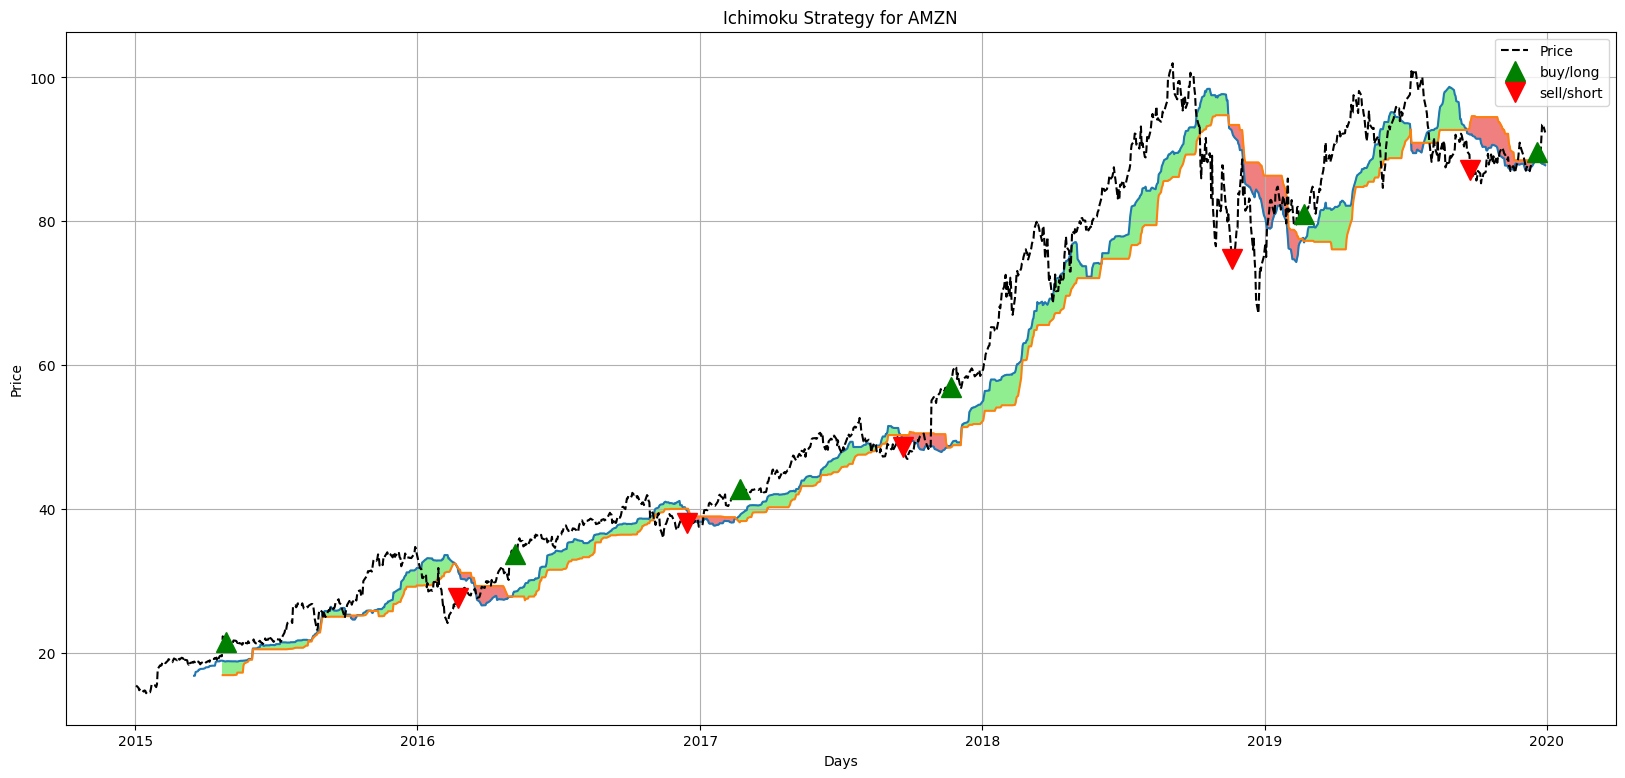

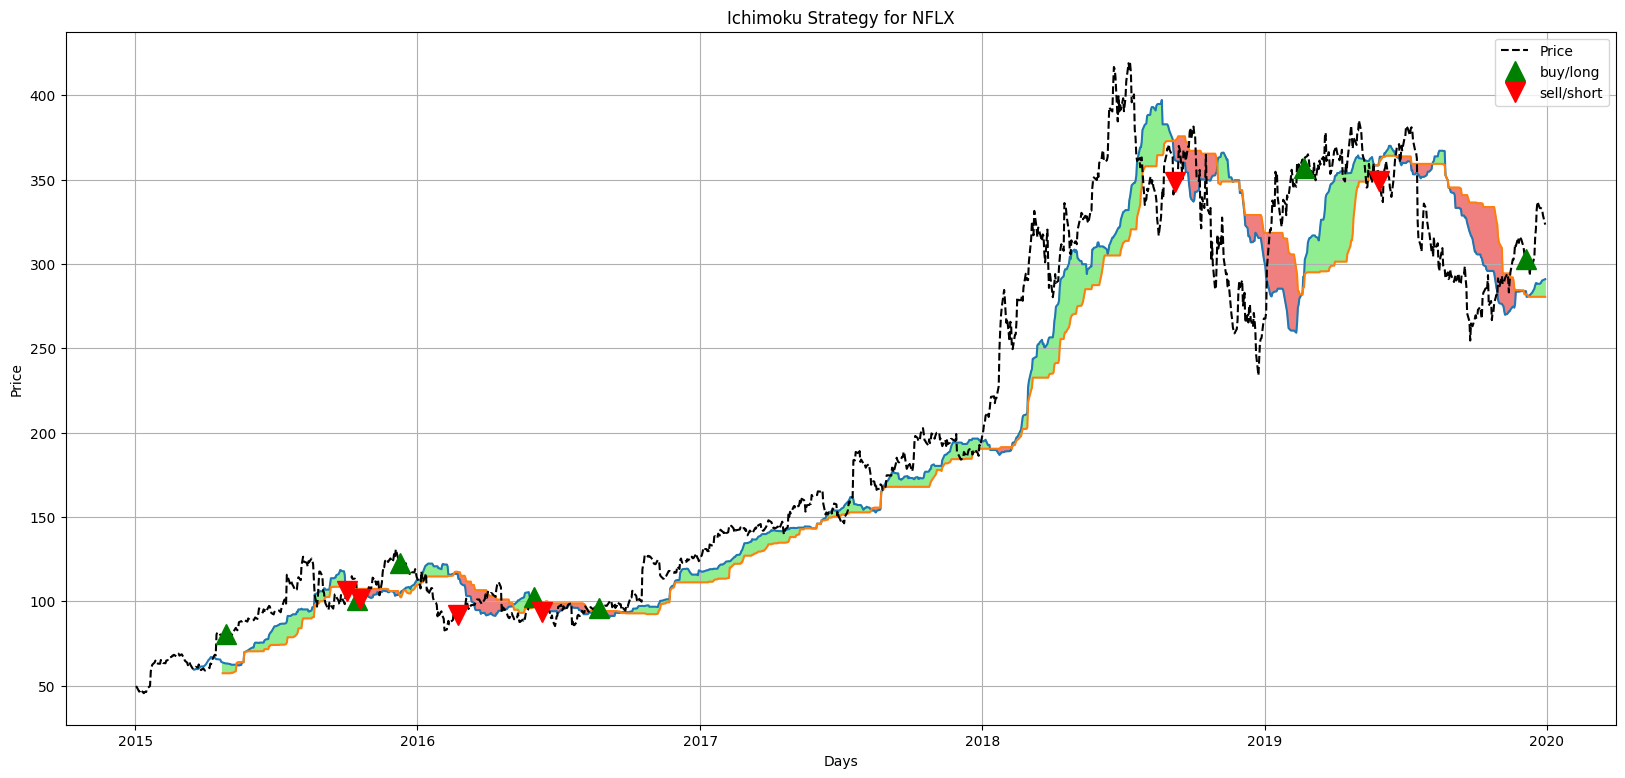

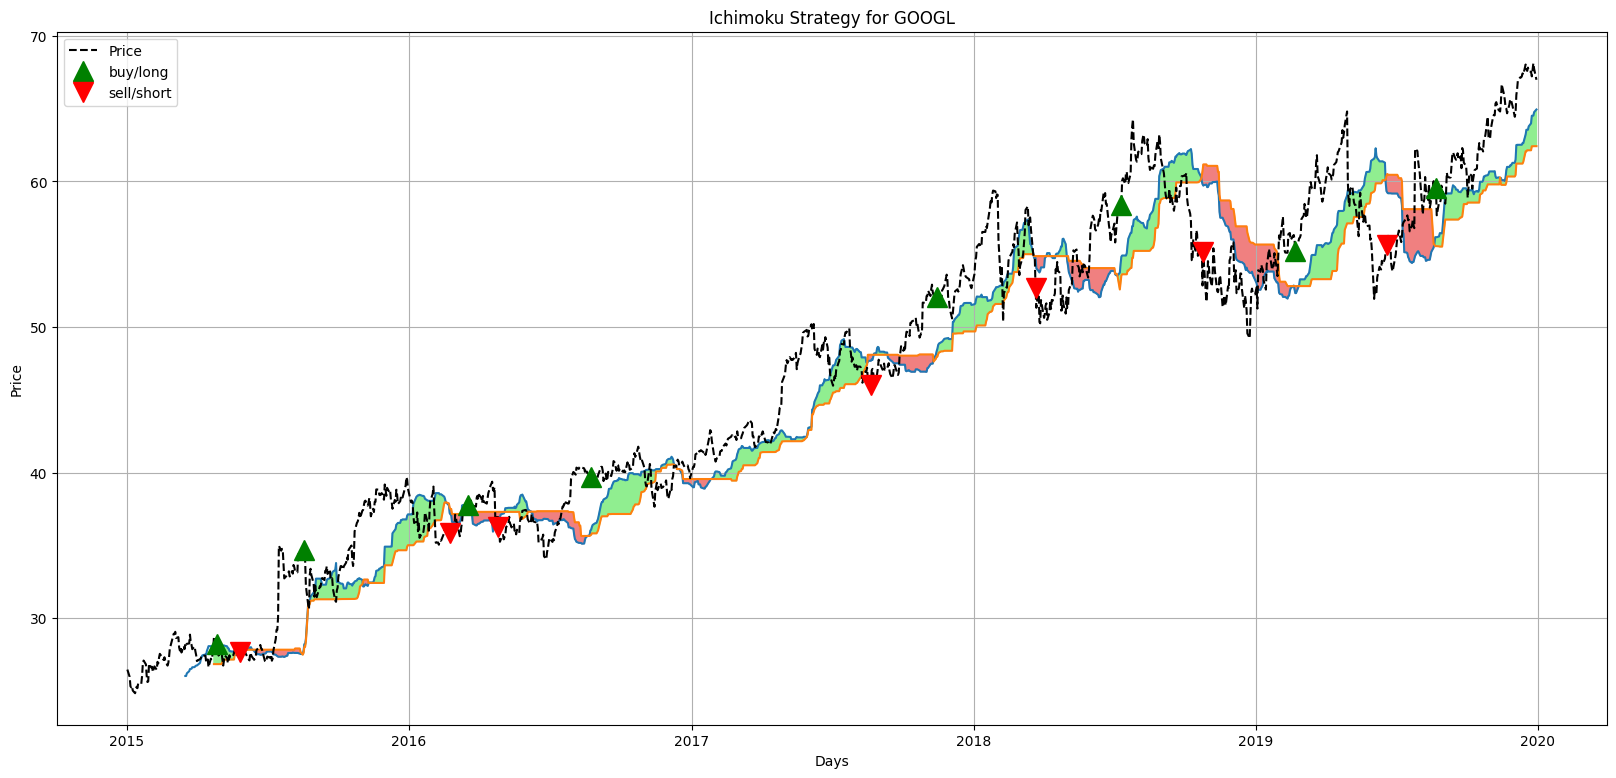

In [ ]:
# generate trading signals on plot
for stock_name, df in stock_name_and_df:

  fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20, 9))


  # Plot Leading Span A with index on the shared x-axis
  ax.plot(df.index, df['lead_span_a'])

  # Plot Leading Span B with index on the shared x-axis
  ax.plot(df.index, df['lead_span_b'])
  # Use the fill_between of ax object to specify where to fill
  ax.fill_between(df.index, df['lead_span_a'], df['lead_span_b'],
                  where=df['lead_span_a'] >= df['lead_span_b'], color='lightgreen')

  ax.fill_between(df.index, df['lead_span_a'], df['lead_span_b'],
                  where=df['lead_span_a'] < df['lead_span_b'], color='lightcoral')
  plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
  plt.plot(df[df['Final Trading Signal'] == 1].index,
          df['Close'][df['Final Trading Signal'] == 1 ],
          '^', markersize = 15, color = 'g', label = 'buy/long')

  # plot ‘sell crossover ’ signals
  plt.plot(df[df['Final Trading Signal'] == -1].index,
          df['Close'][df['Final Trading Signal'] == -1],
          'v', markersize = 15, color = 'r', label = 'sell/short')



  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.title(f"Ichimoku Strategy for {stock_name}")
  plt.legend()
  plt.grid()
  plt.show()


## Variation 2: Ichimoku Strategy with MFI

Trading Rules
1) We will buy if the leading span A crosses over leading span B and the price crosses above the Ichimoku Cloud and the stock is oversold. The value of this cloud will be leading span A’s value if it is an uptrend.
2) We will sell if the leading span A crosses below leading span B and the price crosses below the Ichimoku Cloud and the stock is overbought. The value of this cloud will be the leading span B’s value if it is a downtrend


In [ ]:
# replace position with 0 if indicators are not ready
# buy / sell according to trading rules above
# if position uncertain, give na values that will be replaced later
def generate_trading_rule_ichimoku_mfi(row):
    if (pd.isna(row["MFI"])) or (pd.isna(row["lead_span_b"])):
      return 0
    if (row["MFI signal"] < 0 and row["signal"] == -2):
      return -1
    elif(row["MFI signal"] > 0 and row["signal"] == 2) :
      return 1
    else:
      return np.nan

In [ ]:
# generate trading signal by comparing the diff between the two positions
def generate_trading_signal_ichimoku_mfi(row):
  if ((row["Final Position"] > row["Previous Final Position"]) and (row["Final Position"] > 0) and (row["Previous Final Position"] < 0)):
    return 1
  elif ((row["Final Position"] < row["Previous Final Position"]) and (row["Final Position"] < 0) and (row["Previous Final Position"] > 0)):
    return -1
  else:
    return 0

In [ ]:
# passing in the stock dataframe into the ichimikou cloud strategy
stocks_df = []
stocks_df_with_indicators = []
for stock in stock_list:
  data = yf.download(stock, start=start, end=end)
  stocks_df.append(data)
for stock_df in stocks_df:
  stock_mfi = MFI(df = stock_df)
  stock_mfi.generate_MFI()
  stock_mfi.generate_trading_signal()
  stock_mfi_df = stock_mfi.get_df()[["MFI signal"]]
  # print(stock_mfi_df)
  stock_ichimoku = IchimokuCloud(stock_df=stock_df)
  stock_ichimoku.generate_lines()

  stock_ichimoku.generate_trading_position()
  stock_ichimoku_df = stock_ichimoku.get_df()

  stock_combined_indicators = stock_ichimoku_df
  # to resolve lookahead bias
  stock_combined_indicators["Final Position"] = stock_combined_indicators.apply(generate_trading_rule_ichimoku_mfi, axis = 1)
  stock_combined_indicators["Final Position"] = stock_combined_indicators["Final Position"].fillna(method = "ffill").shift()
  stock_combined_indicators["Previous Final Position"] = stock_combined_indicators["Final Position"].shift()
  stock_combined_indicators["Final Trading Signal"] = stock_combined_indicators.apply(generate_trading_signal_ichimoku_mfi, axis = 1)
  stocks_df_with_indicators.append(stock_combined_indicators)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Long short status

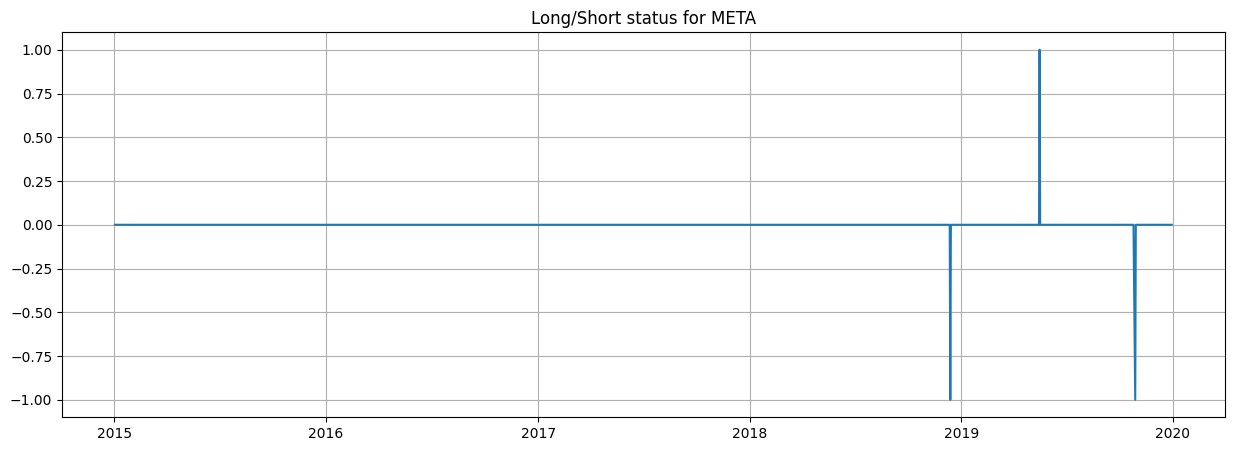

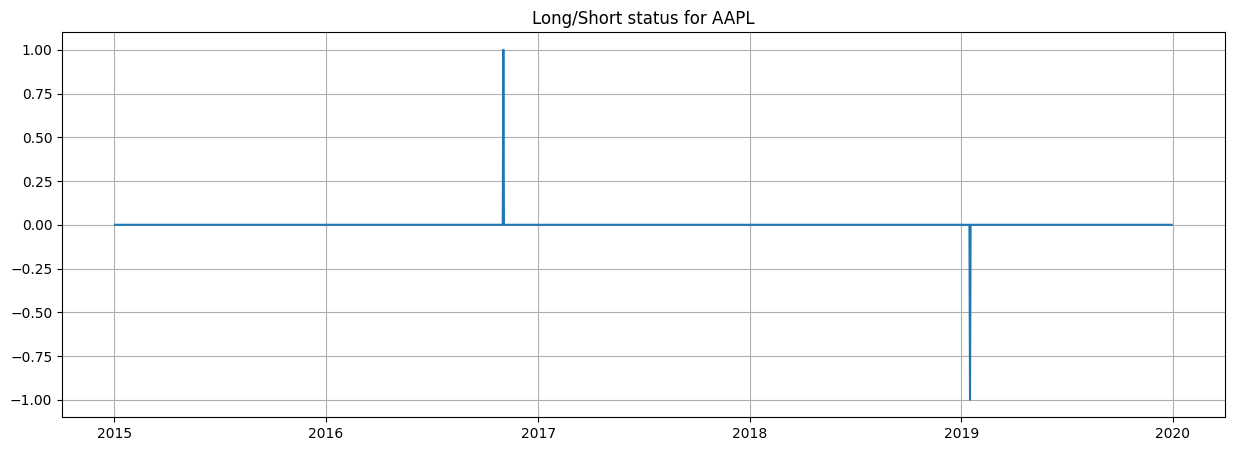

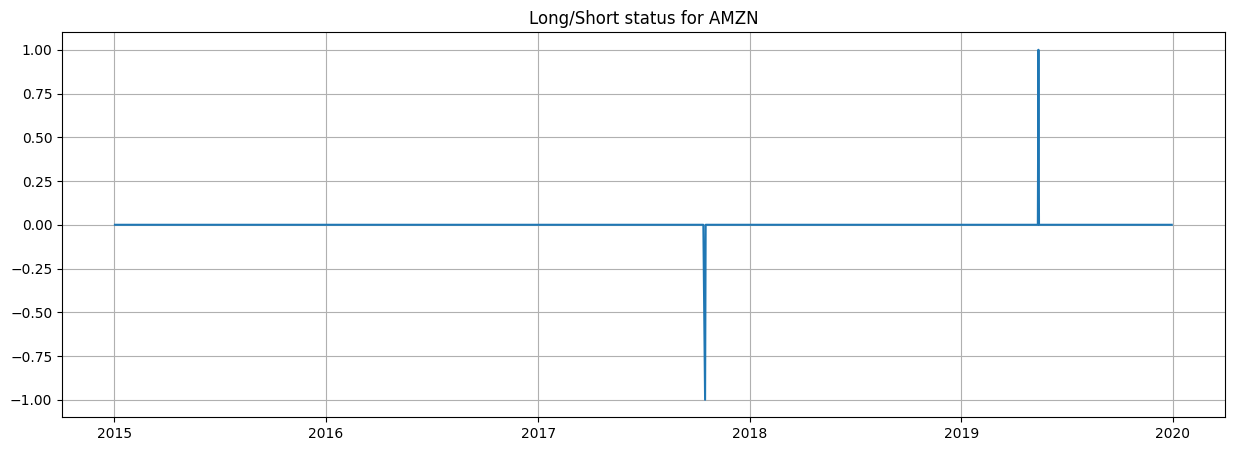

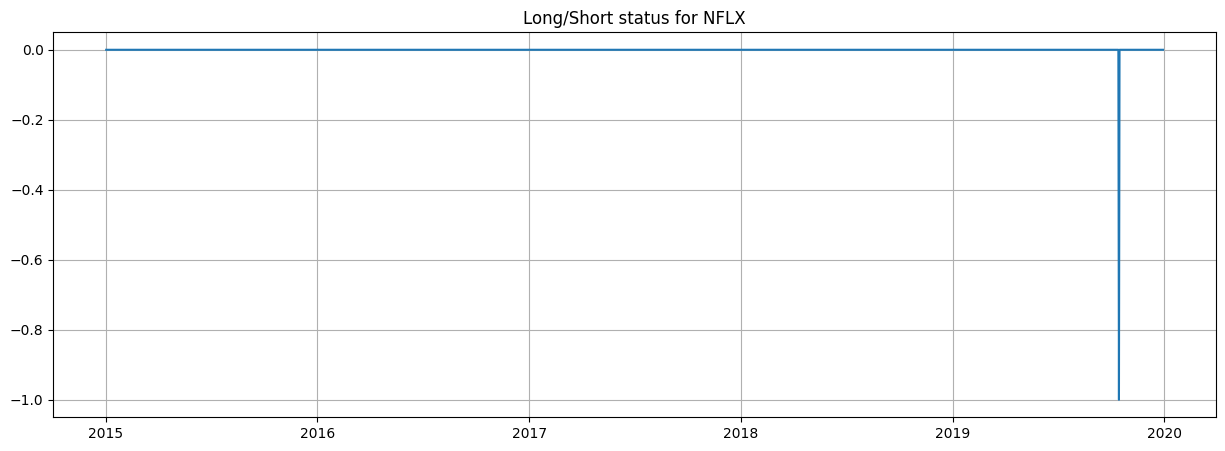

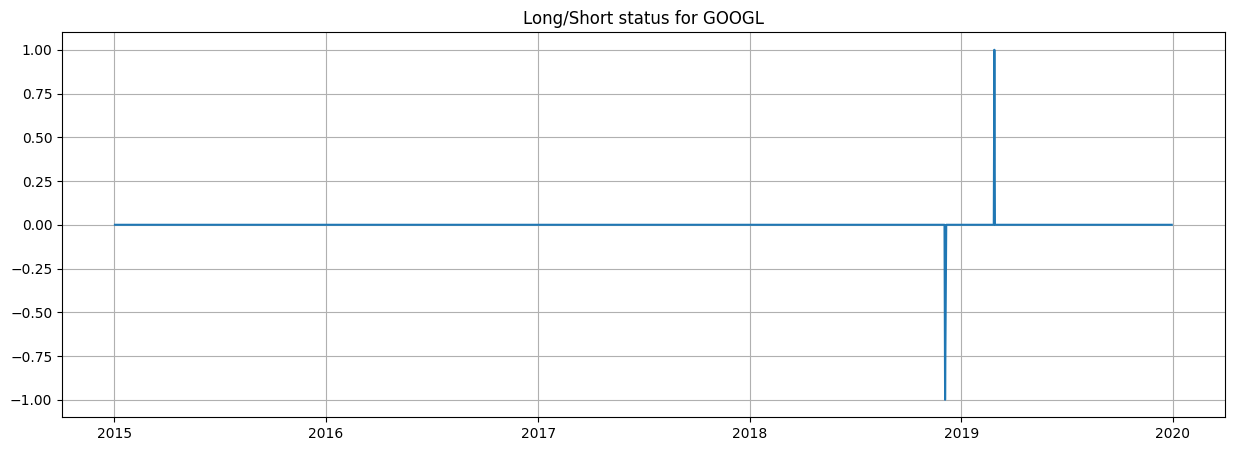

In [ ]:
# long short status
stock_list = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
stock_name_and_df = list(zip(stock_list, stocks_df_with_indicators))
for stock_name, s  in stock_name_and_df:
  plt.figure(figsize=(15,5))
  plt.plot(s["Final Trading Signal"])
  plt.title(f"Long/Short status for {stock_name}")
  plt.grid()
  plt.show()

In [ ]:
# calculating returns
for df in stocks_df_with_indicators:
  df["Stock Returns"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
  df["Stock Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
  df["Strategy Returns"] = df["Stock Returns"] * df["Final Position"]
  df["Strategy Log Returns"] = df["Stock Log Returns"] * df["Final Position"]


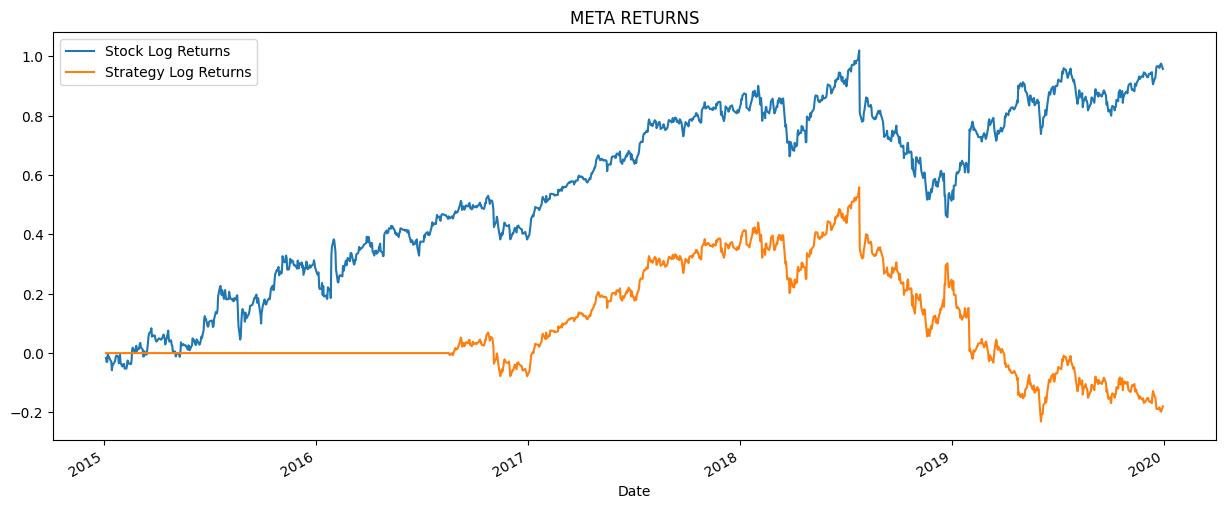

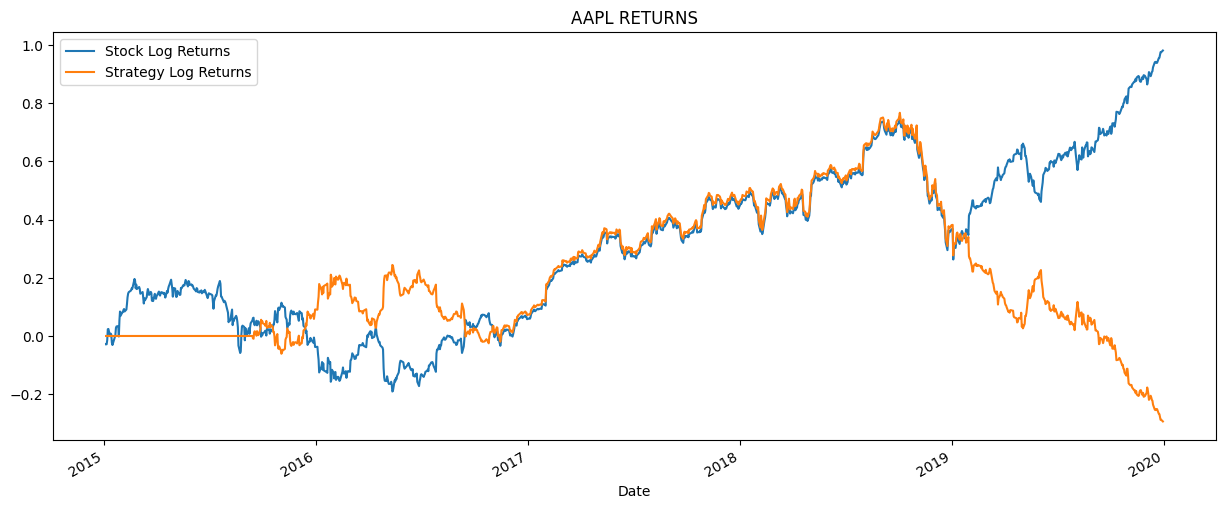

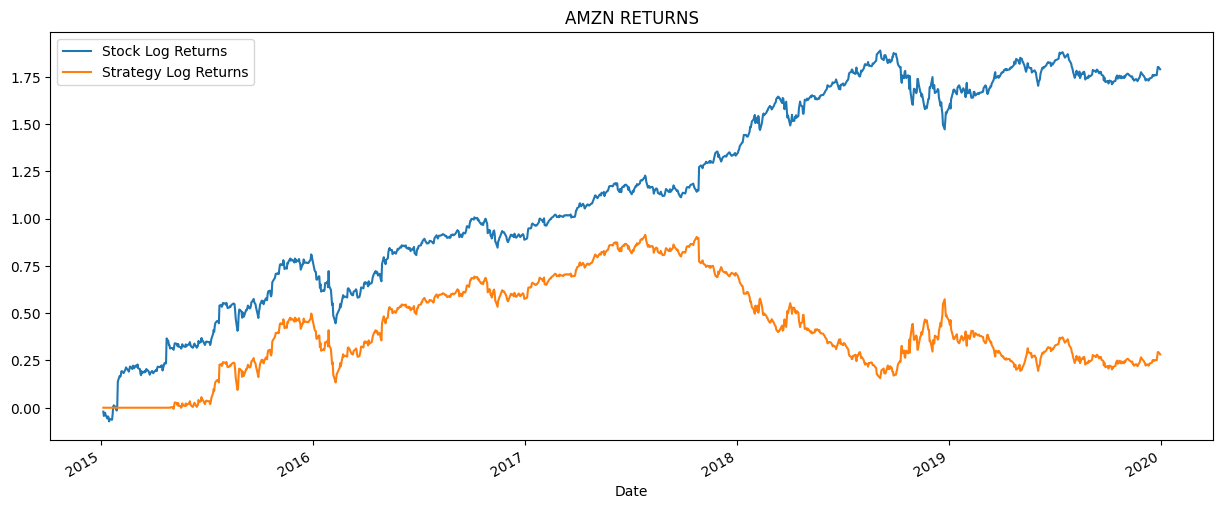

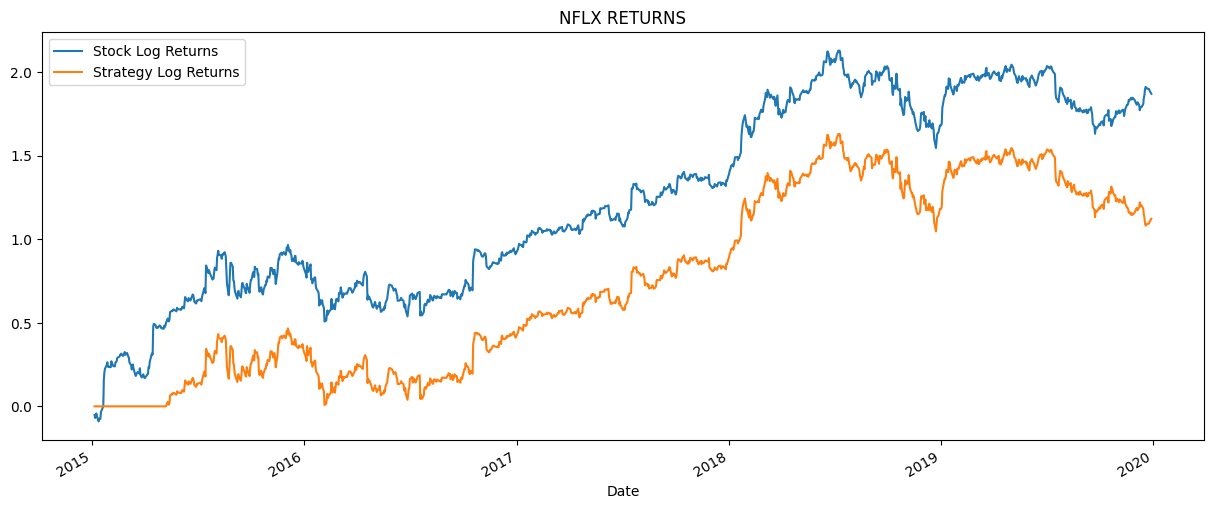

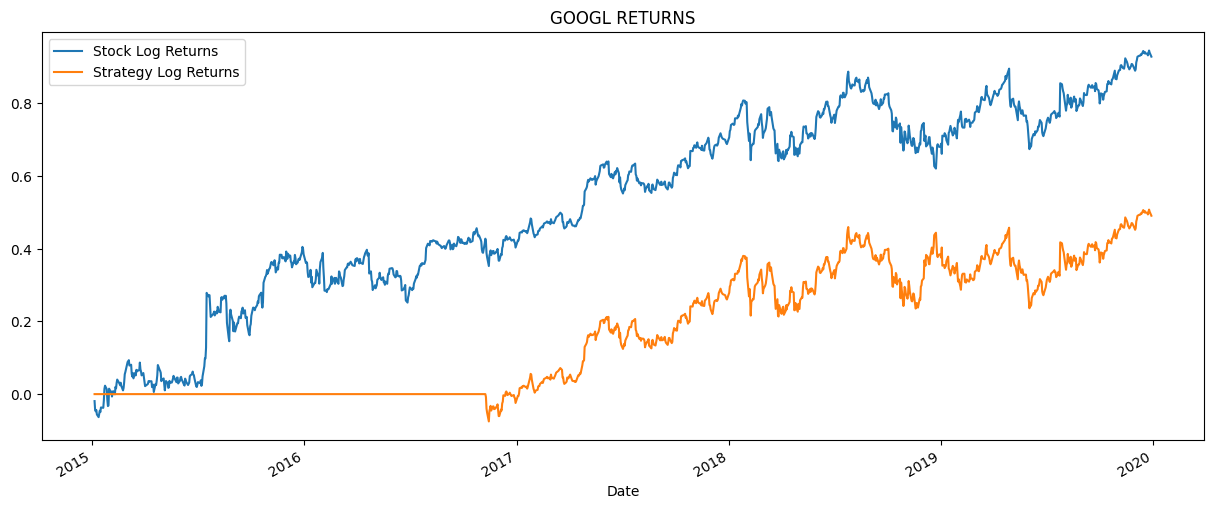

In [ ]:
# plotting returns
for stock_name, df in stock_name_and_df:
  df[["Stock Log Returns", "Strategy Log Returns"]].cumsum().plot(figsize=(15,6), title = f"{stock_name} RETURNS")


In [ ]:
for stock_name, df in stock_name_and_df:
  final_stock_return = (df["Stock Log Returns"].sum())
  final_strategy_return = (df["Strategy Log Returns"].sum())
  print(f"{stock_name} final_stock_return {final_stock_return}")
  print(f"{stock_name} final_strategy_return {final_strategy_return} \n")


META final_stock_return 0.9576663584490293
META final_strategy_return -0.17951094942174364 

AAPL final_stock_return 0.9807377281908798
AAPL final_strategy_return -0.2935634451073707 

AMZN final_stock_return 1.78947174945224
AMZN final_strategy_return 0.2820299108029579 

NFLX final_stock_return 1.8696217621324844
NFLX final_strategy_return 1.122318567103736 

GOOGL final_stock_return 0.9281807758088632
GOOGL final_strategy_return 0.4906361527724817 



In [ ]:
meta = stocks_df_with_indicators[0]
aapl = stocks_df_with_indicators[1]
amzn = stocks_df_with_indicators[2]
nflx = stocks_df_with_indicators[3]
googl = stocks_df_with_indicators[4]
portfolio_returns = (meta["Strategy Returns"] + aapl["Strategy Returns"] + amzn["Strategy Returns"] + nflx["Strategy Returns"] + googl["Strategy Returns"]) / 5
ichimoku_and_mfi_portfolio_returns = portfolio_returns
# R = log (R +1)
portfolio_returns.apply(np.log1p).sum()

0.34037192145207285

<Axes: title={'center': 'Portfolio Returns (Ichimoku + MFI)'}, xlabel='Date'>

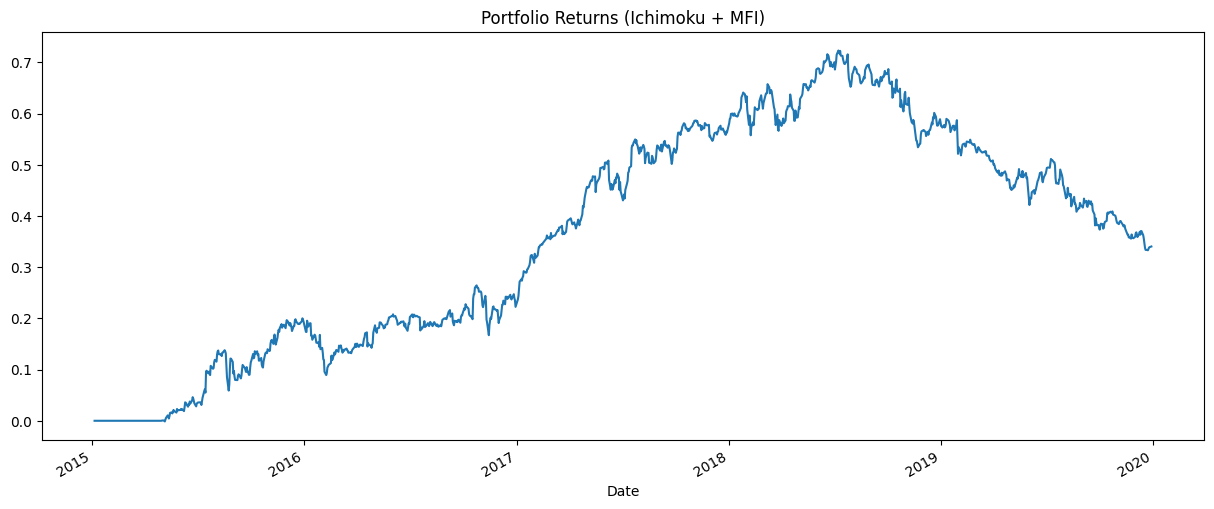

In [ ]:
portfolio_returns.apply(np.log1p).cumsum().plot(figsize=(15,6), title = f"Portfolio Returns (Ichimoku + MFI)")

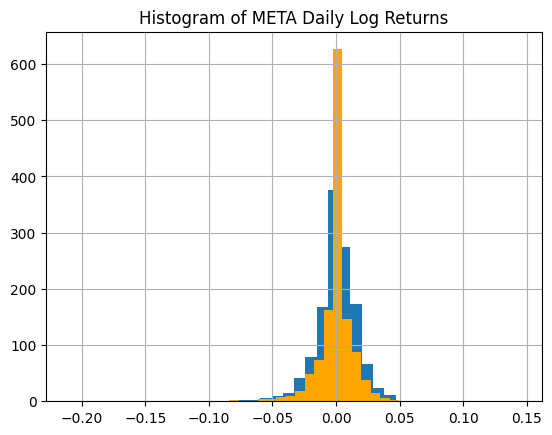

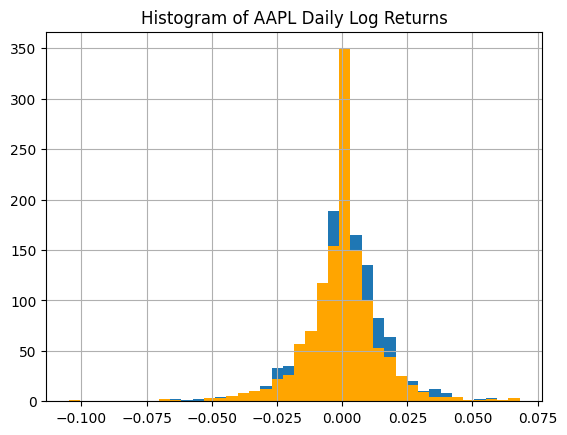

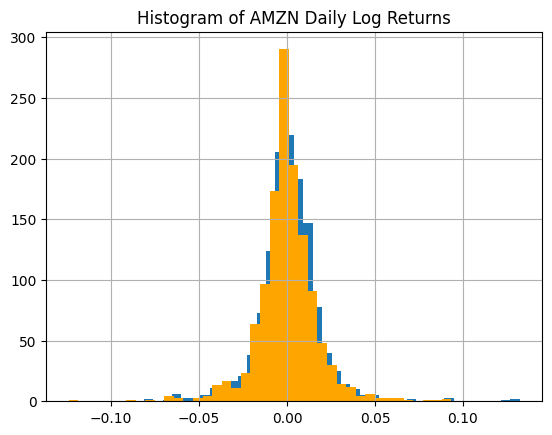

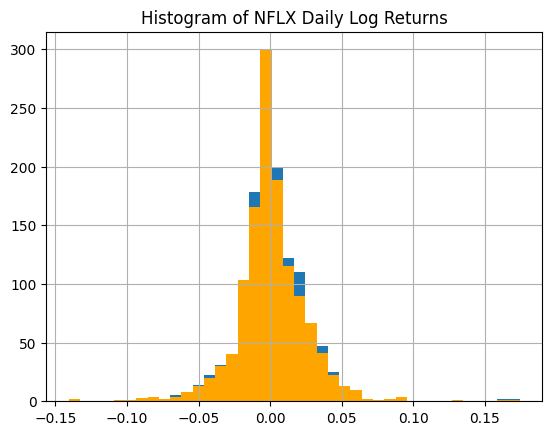

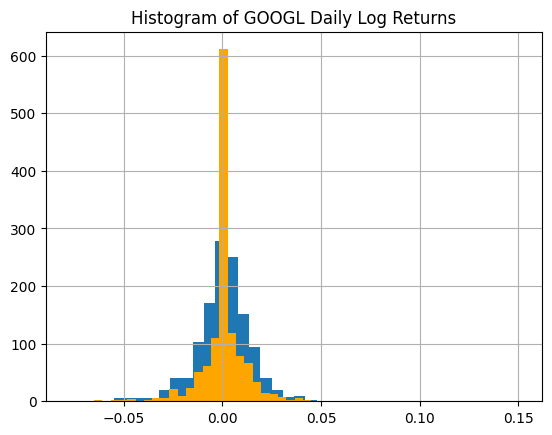

In [ ]:
# generating histogram plot
for stock_name, df in stock_name_and_df:
  plt.hist(df["Stock Log Returns"], bins = 40)
  plt.hist(df["Strategy Log Returns"], bins = 40, color = "Orange")
  plt.title(f"Histogram of {stock_name} Daily Log Returns")
  plt.grid()
  plt.show()

In [ ]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''
benchmark_symbol = "^GSPC"
start = "2015-01-01"
end = "2019-12-31"
for stock_name, df in stock_name_and_df:
  # 1.  Annual Mean Returns or Expected returns
  daily_ret = df[["Stock Log Returns", "Strategy Log Returns"]].mean()
  annual_ret =  daily_ret * 252
  #print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

  # Convert back to regular returns
  # Due to the statistical challenges, we cannot perform calculations on gross returns,
  # Hence, we do that in log returns, and then convert back to regular

  annual_regular_ret = np.exp(annual_ret)-1
  print(f'Annual {stock_name} regular returns are: \n',annual_regular_ret)

  #2. Annual Standard deviation
  daily_std = df[["Stock Log Returns", "Strategy Log Returns"]].std()
  annual_std =  daily_std * (252 **0.5)
  #print(f'Annual log std is: \n', annual_std) # Note that these are the log returns

  #Convert to regular
  daily_regular_std = (np.exp(df[["Stock Log Returns", "Strategy Log Returns"]])-1).std()
  annual_regular_std =  daily_regular_std * (252 **0.5)
  print(f'Annual regular {stock_name} standard deviation is: \n', annual_regular_std) # Note that these are the log returns

  #3. Sharpe Ratio
  # Since we have already calculated the annual returns and risk we can use them

  sr = annual_regular_ret/ annual_regular_std
  print(f" The {stock_name} Sharpe Ratio is : \n ", sr, "\n\n")


Annual META regular returns are: 
 Stock Log Returns       0.211844
Strategy Log Returns   -0.035376
dtype: float64
Annual regular META standard deviation is: 
 Stock Log Returns       0.282297
Strategy Log Returns    0.230330
dtype: float64
 The META Sharpe Ratio is : 
  Stock Log Returns       0.750429
Strategy Log Returns   -0.153587
dtype: float64 


Annual AAPL regular returns are: 
 Stock Log Returns       0.217467
Strategy Log Returns   -0.057199
dtype: float64
Annual regular AAPL standard deviation is: 
 Stock Log Returns       0.248711
Strategy Log Returns    0.226638
dtype: float64
 The AAPL Sharpe Ratio is : 
  Stock Log Returns       0.874375
Strategy Log Returns   -0.252379
dtype: float64 


Annual AMZN regular returns are: 
 Stock Log Returns       0.431946
Strategy Log Returns    0.058217
dtype: float64
Annual regular AMZN standard deviation is: 
 Stock Log Returns       0.292617
Strategy Log Returns    0.273175
dtype: float64
 The AMZN Sharpe Ratio is : 
  Stock Log Ret

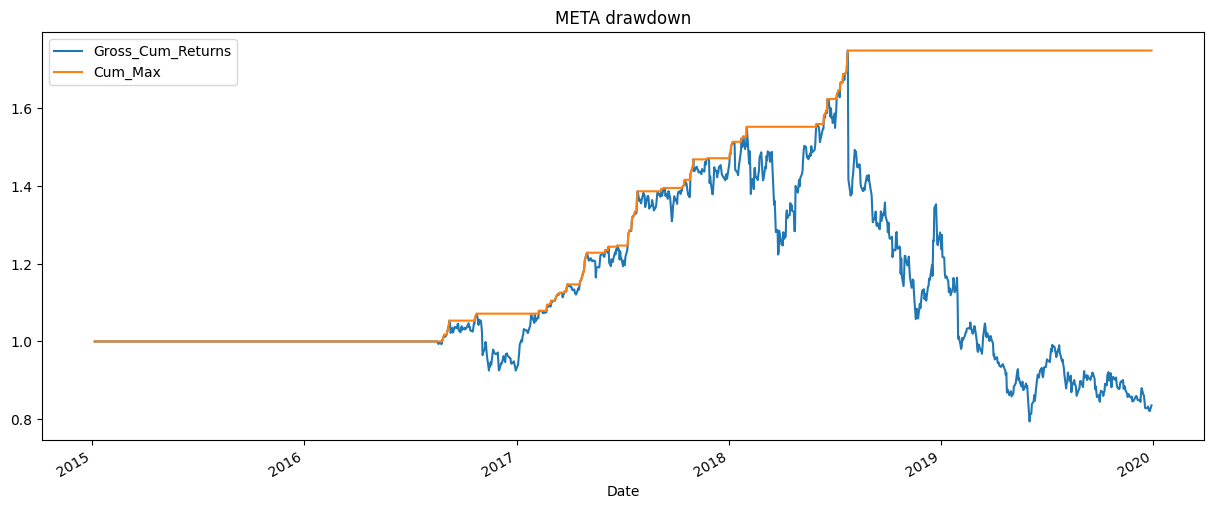

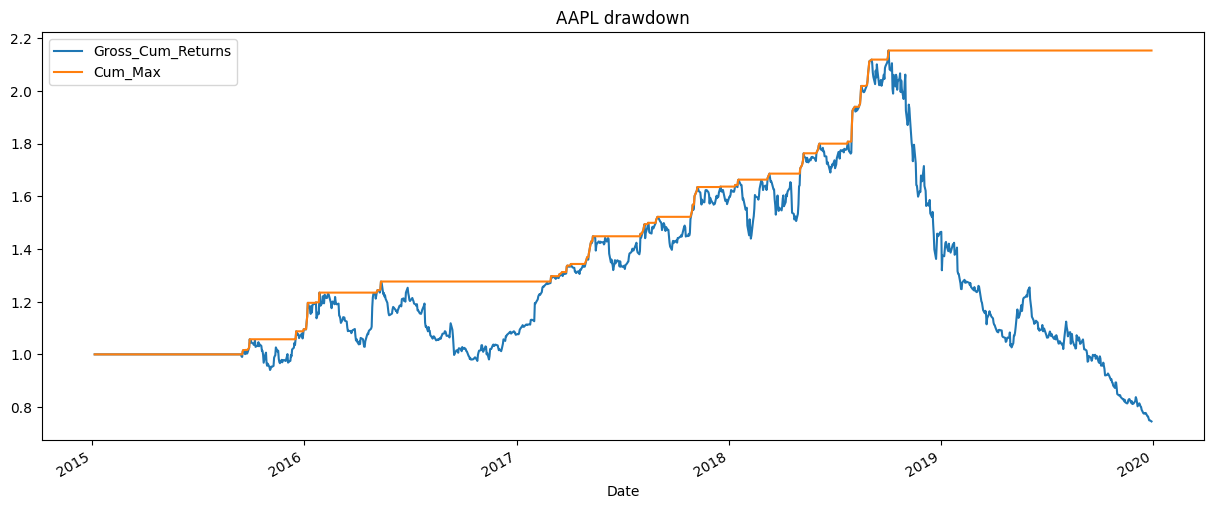

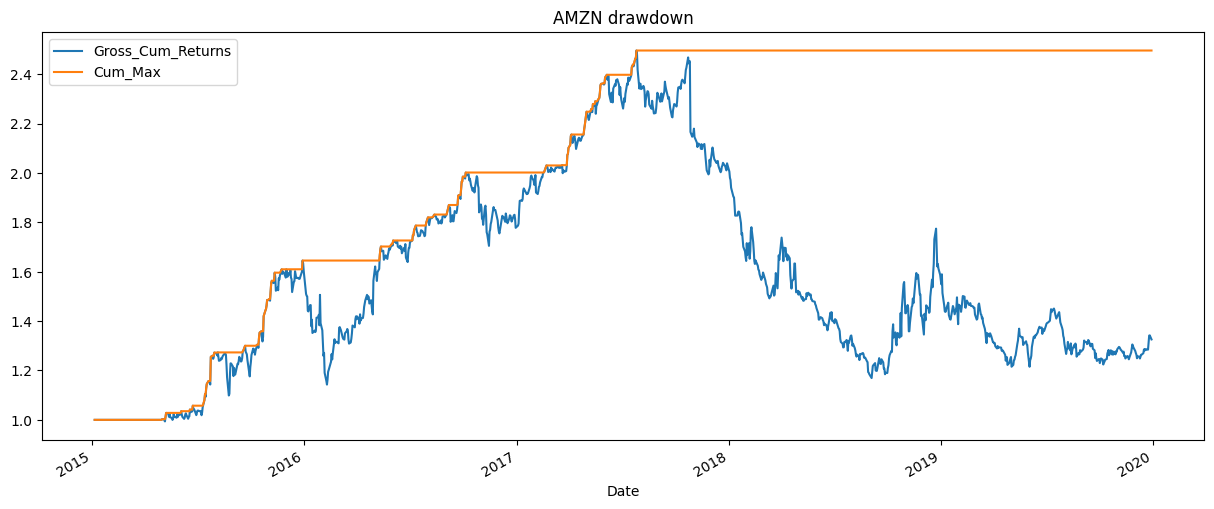

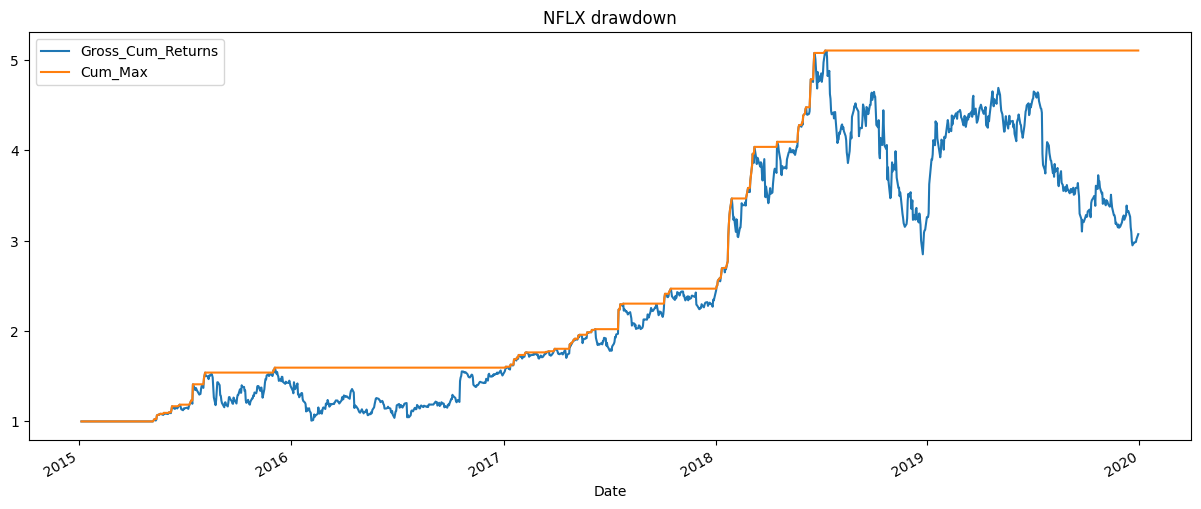

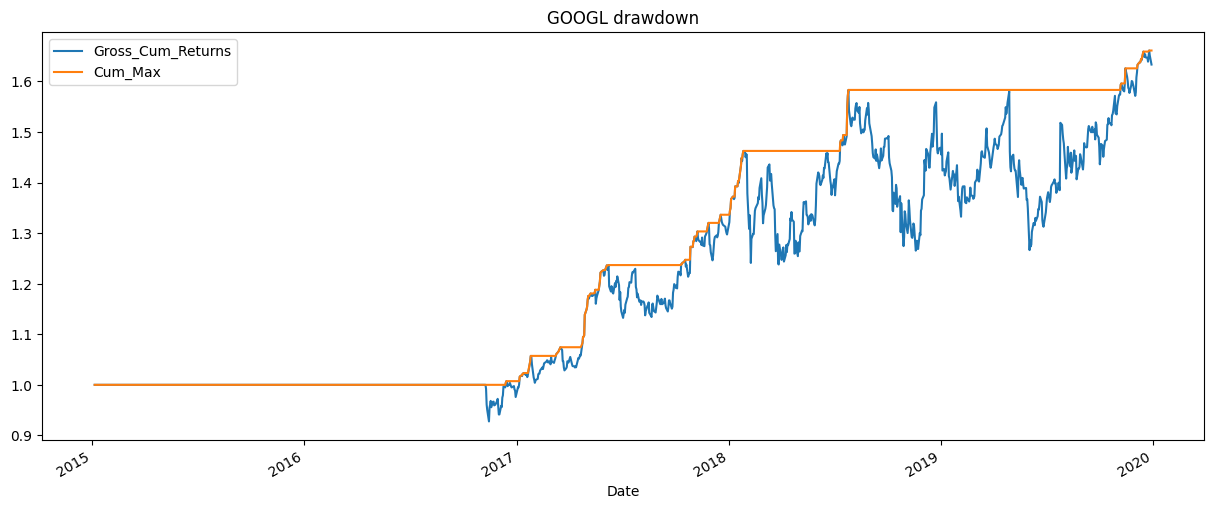

In [ ]:
for stock_name, df in stock_name_and_df:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()
  df[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6), title = f"{stock_name} drawdown")

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()


  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]

  zero_periods

In [ ]:
for stock_name, df in stock_name_and_df:
  df["Gross_Cum_Returns"] = df["Strategy Log Returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
  df["Cum_Max"] = df["Gross_Cum_Returns"].cummax()

  drawdown = df["Cum_Max"] - df["Gross_Cum_Returns"] # it gives the difference between orange and blue

  df["drawdown"] = drawdown

  # The maximum difference is refered as "Drawdown"

  max_drawdown = df["drawdown"].max()
  print(f"{stock_name} max drawdown {max_drawdown}")

  # Although we know the max drawdown, we dont know how long it happened.
  # Lets calculate tha max drawdown period
  # The idea is to store all the points where the blue and orange meet (i.e. gross vs maximum)
  # and then calculate the difference between these points. The highest difference is the longest drawdown period.

  zero_periods = drawdown[drawdown == 0]
  print(f"{stock_name} zero periods {zero_periods}")

META max drawdown 0.9545313413048049
META zero periods Date
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
             ... 
2018-07-13    0.0
2018-07-17    0.0
2018-07-23    0.0
2018-07-24    0.0
2018-07-25    0.0
Length: 480, dtype: float64
AAPL max drawdown 1.407250032837833
AAPL zero periods Date
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
             ... 
2018-08-30    0.0
2018-08-31    0.0
2018-09-04    0.0
2018-10-02    0.0
2018-10-03    0.0
Length: 252, dtype: float64
AMZN max drawdown 1.3267553181891516
AMZN zero periods Date
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
             ... 
2017-07-19    0.0
2017-07-20    0.0
2017-07-24    0.0
2017-07-25    0.0
2017-07-26    0.0
Length: 173, dtype: float64
NFLX max drawdown 2.2548380497733063
NFLX zero periods Date
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09 

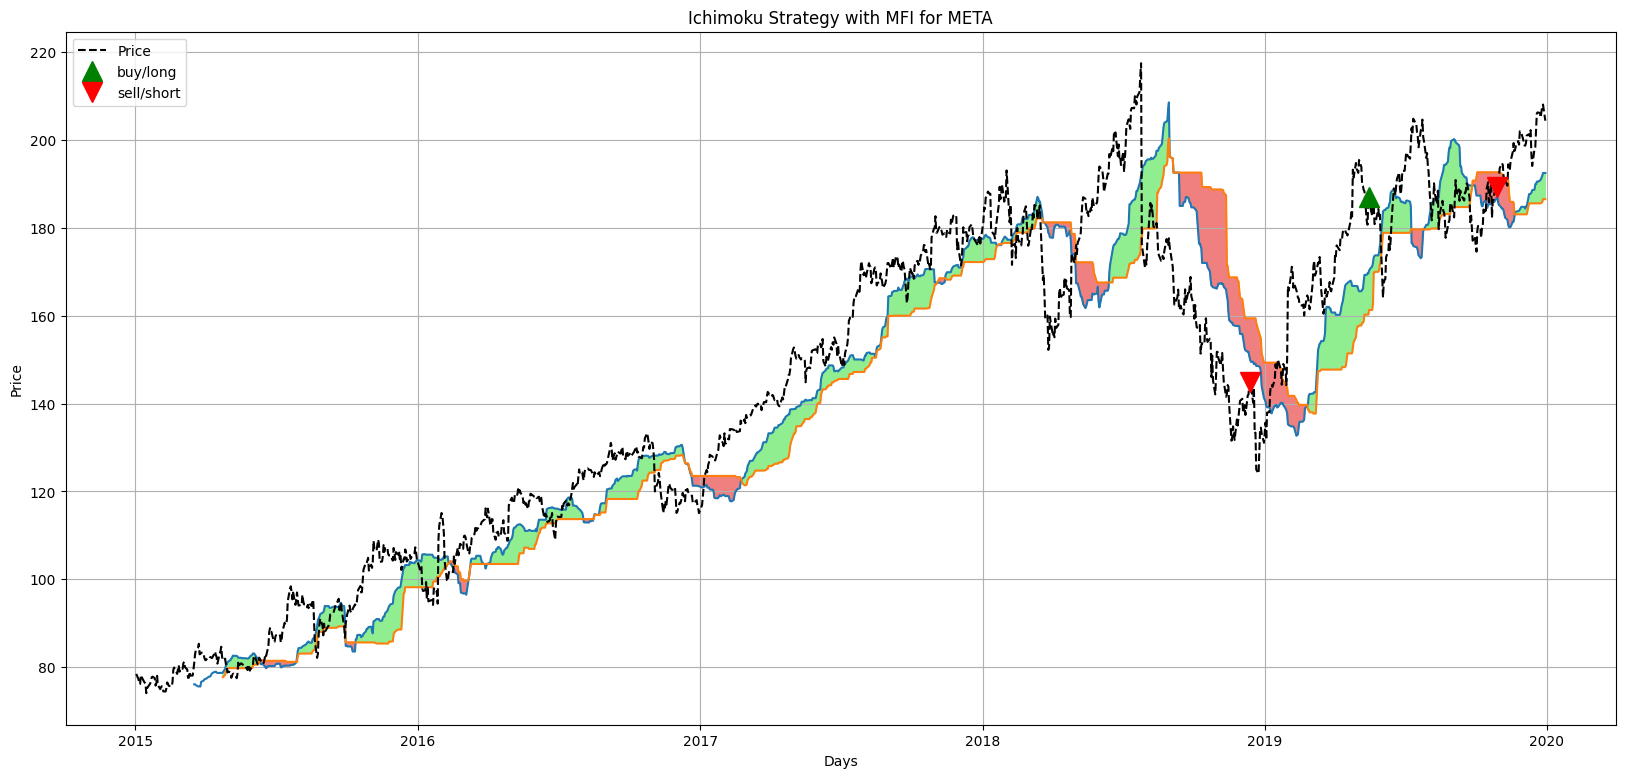

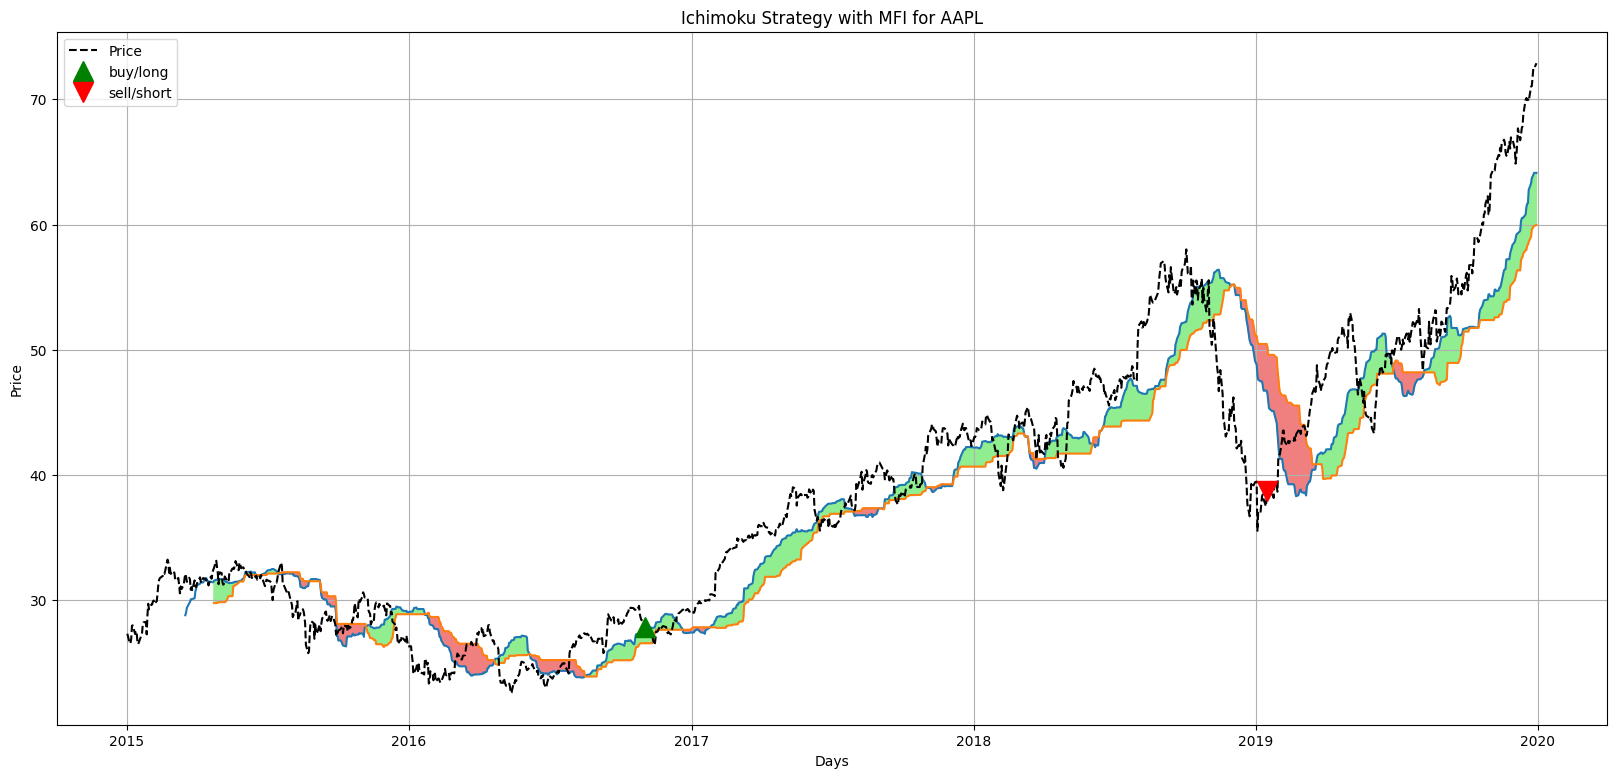

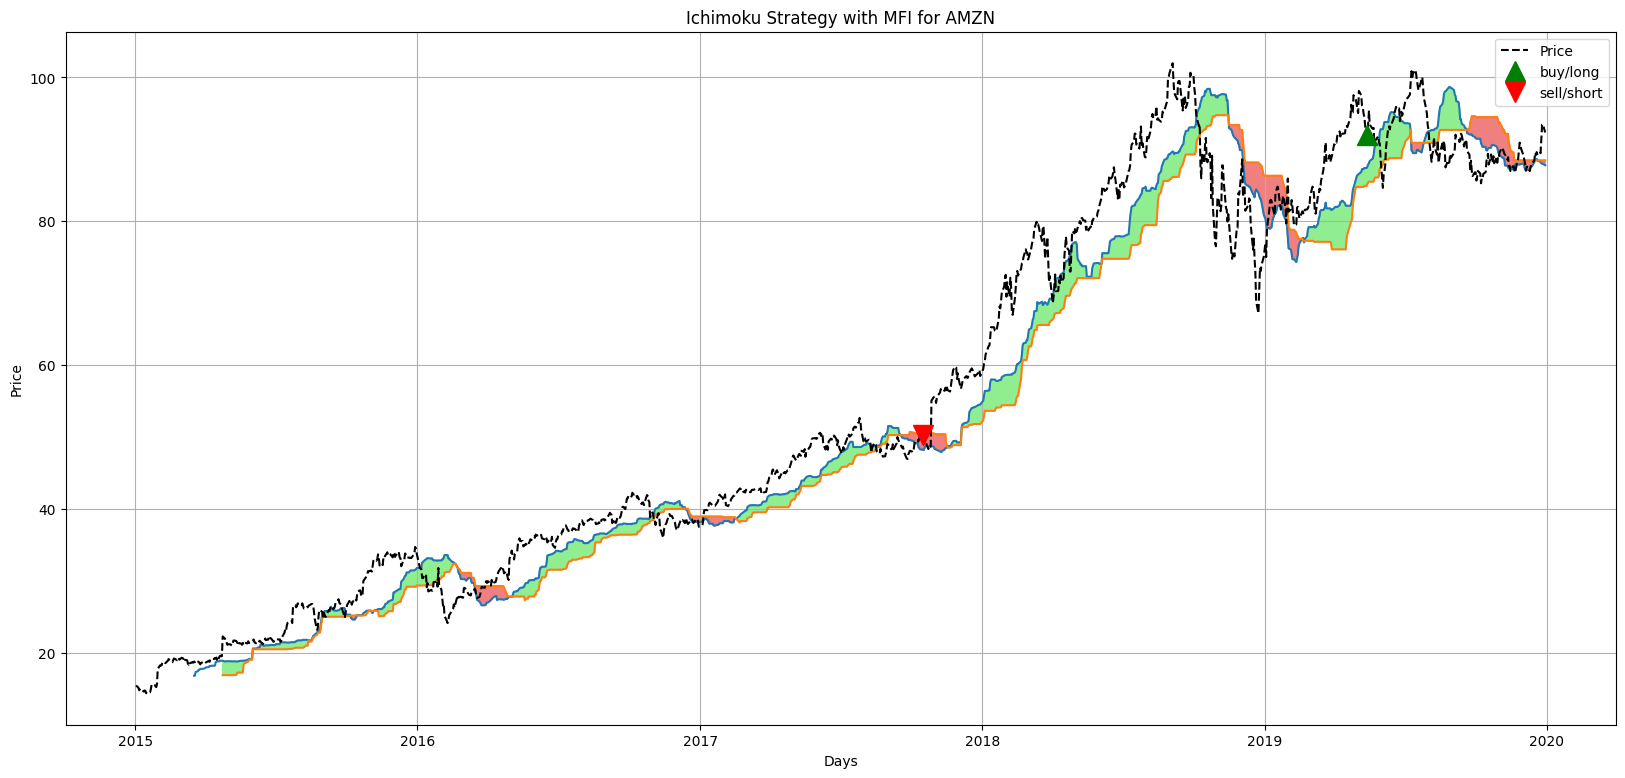

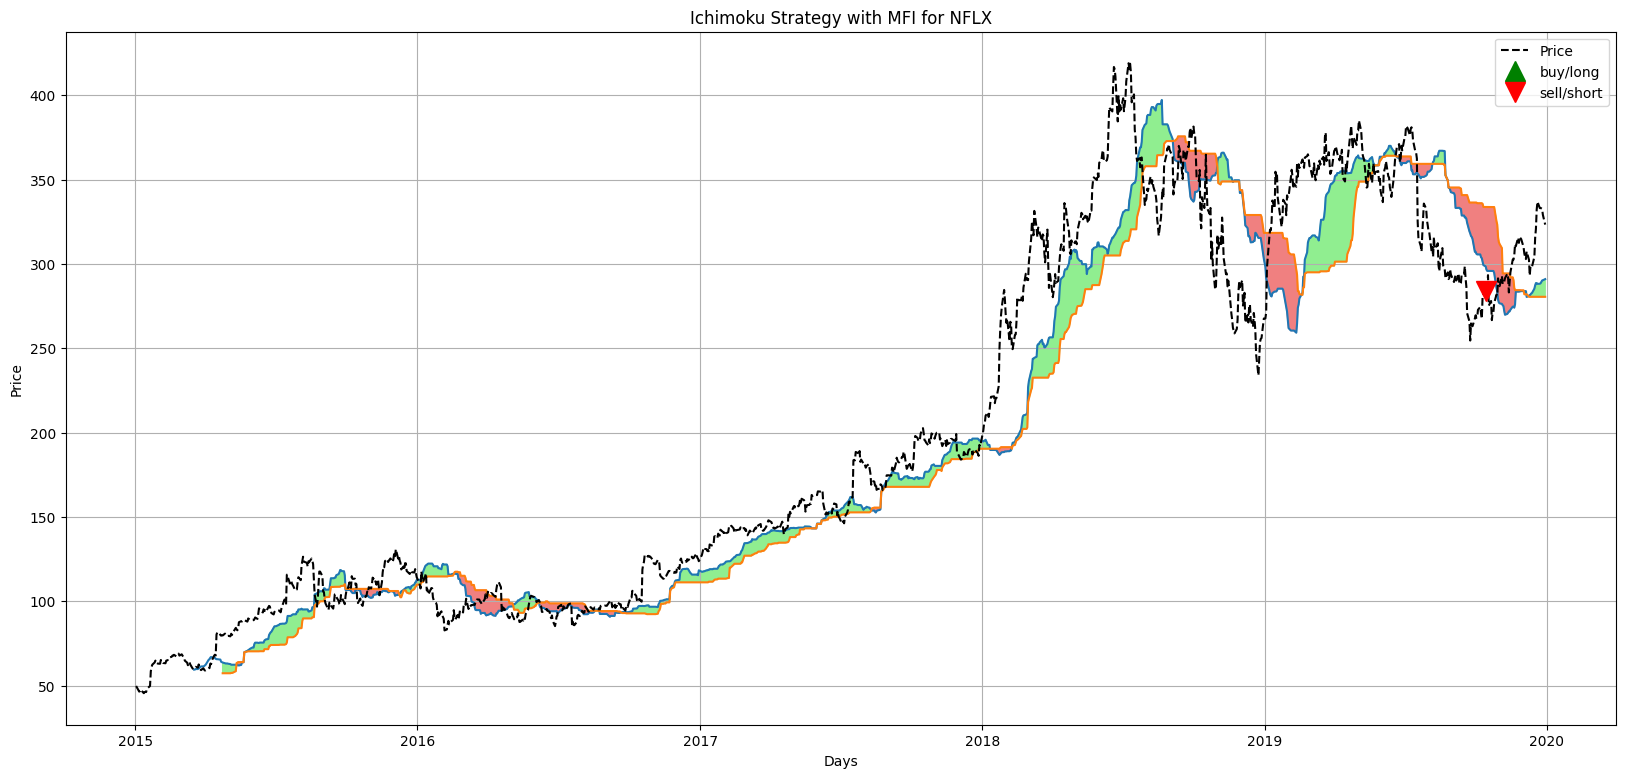

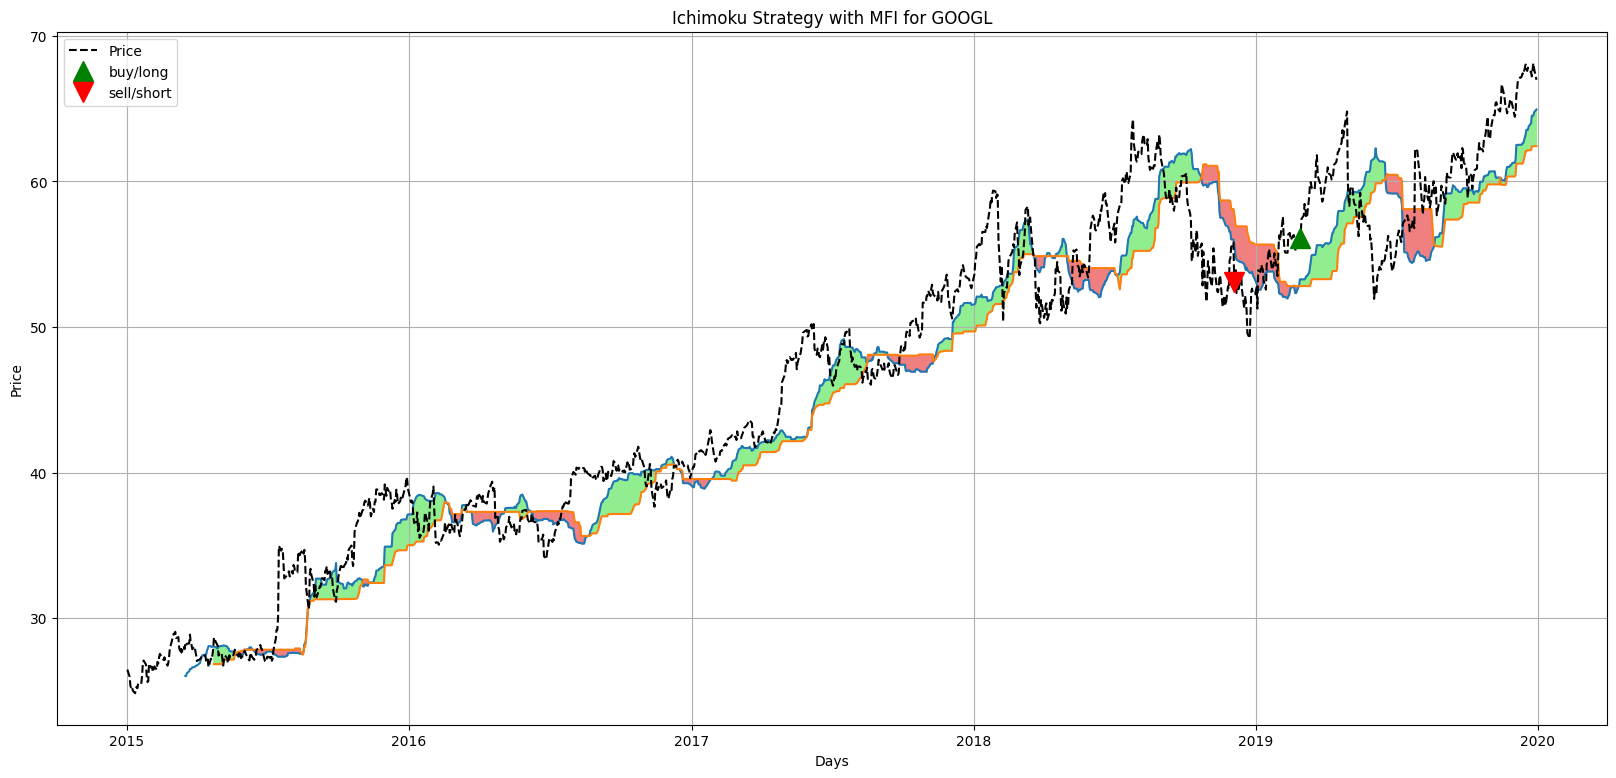

In [ ]:
for stock_name, df in stock_name_and_df:

  fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20, 9))


  # Plot Leading Span A with index on the shared x-axis
  ax.plot(df.index, df['lead_span_a'])

  # Plot Leading Span B with index on the shared x-axis
  ax.plot(df.index, df['lead_span_b'])
  # Use the fill_between of ax object to specify where to fill
  ax.fill_between(df.index, df['lead_span_a'], df['lead_span_b'],
                  where=df['lead_span_a'] >= df['lead_span_b'], color='lightgreen')

  ax.fill_between(df.index, df['lead_span_a'], df['lead_span_b'],
                  where=df['lead_span_a'] < df['lead_span_b'], color='lightcoral')
  plt.plot(df["Close"] ,color='black', label='Price', linestyle='dashed')
  plt.plot(df[df['Final Trading Signal'] == 1].index,
          df['Close'][df['Final Trading Signal'] == 1 ],
          '^', markersize = 15, color = 'g', label = 'buy/long')

  # plot ‘sell crossover ’ signals
  plt.plot(df[df['Final Trading Signal'] == -1].index,
          df['Close'][df['Final Trading Signal'] == -1],
          'v', markersize = 15, color = 'r', label = 'sell/short')



  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.title(f"Ichimoku Strategy with MFI for {stock_name}")
  plt.legend()
  plt.grid()
  plt.show()


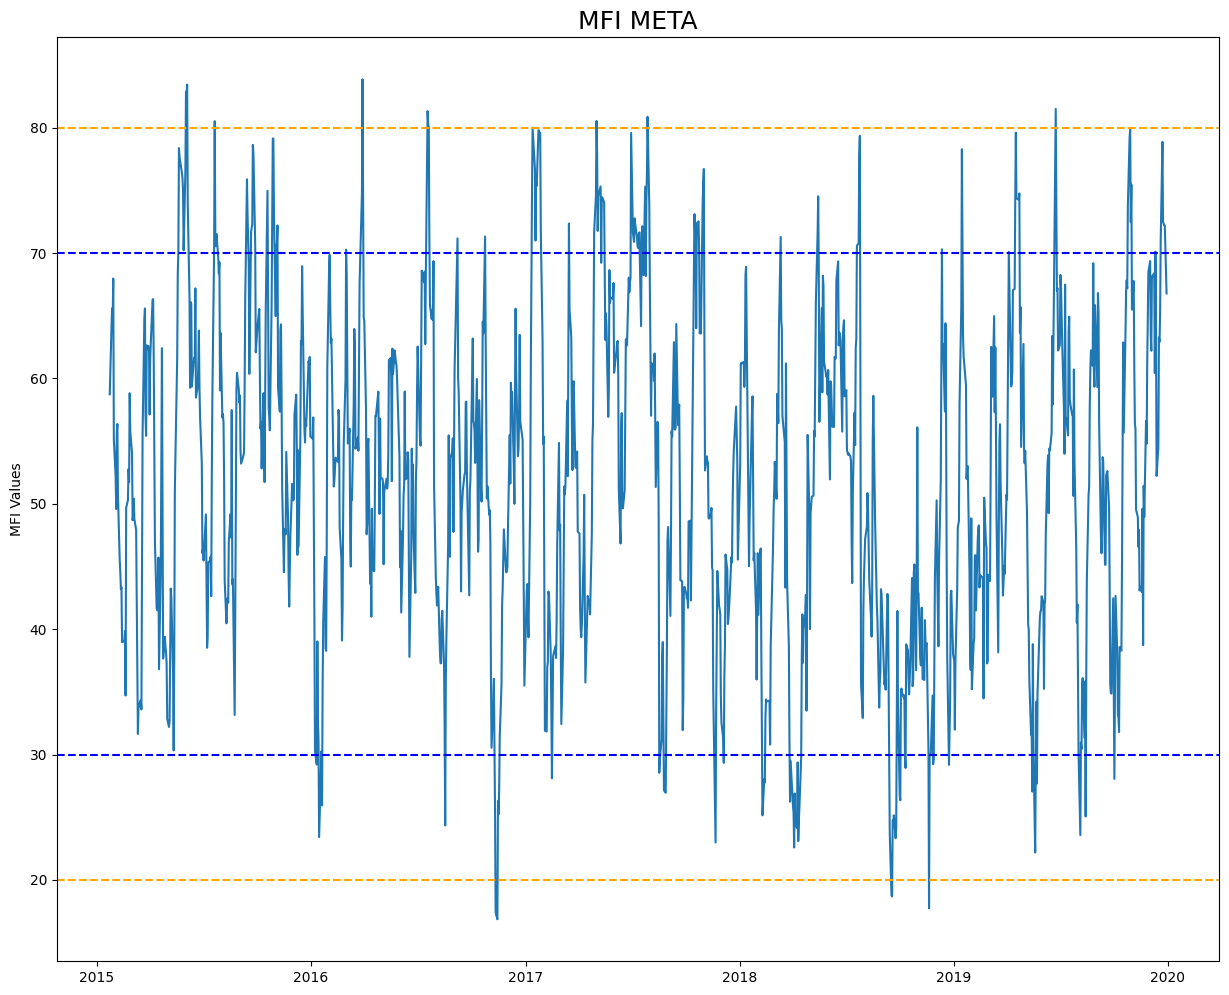

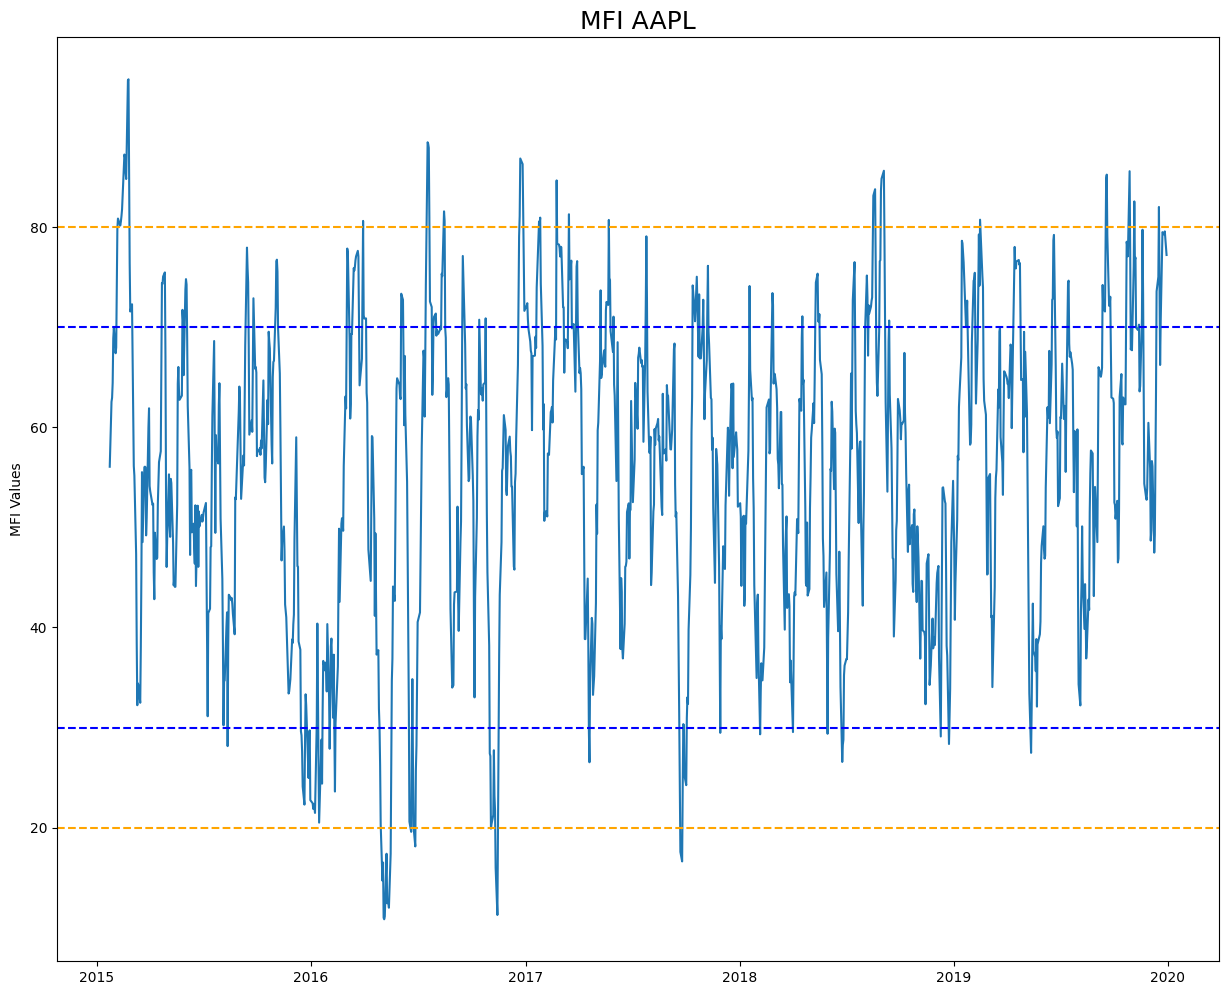

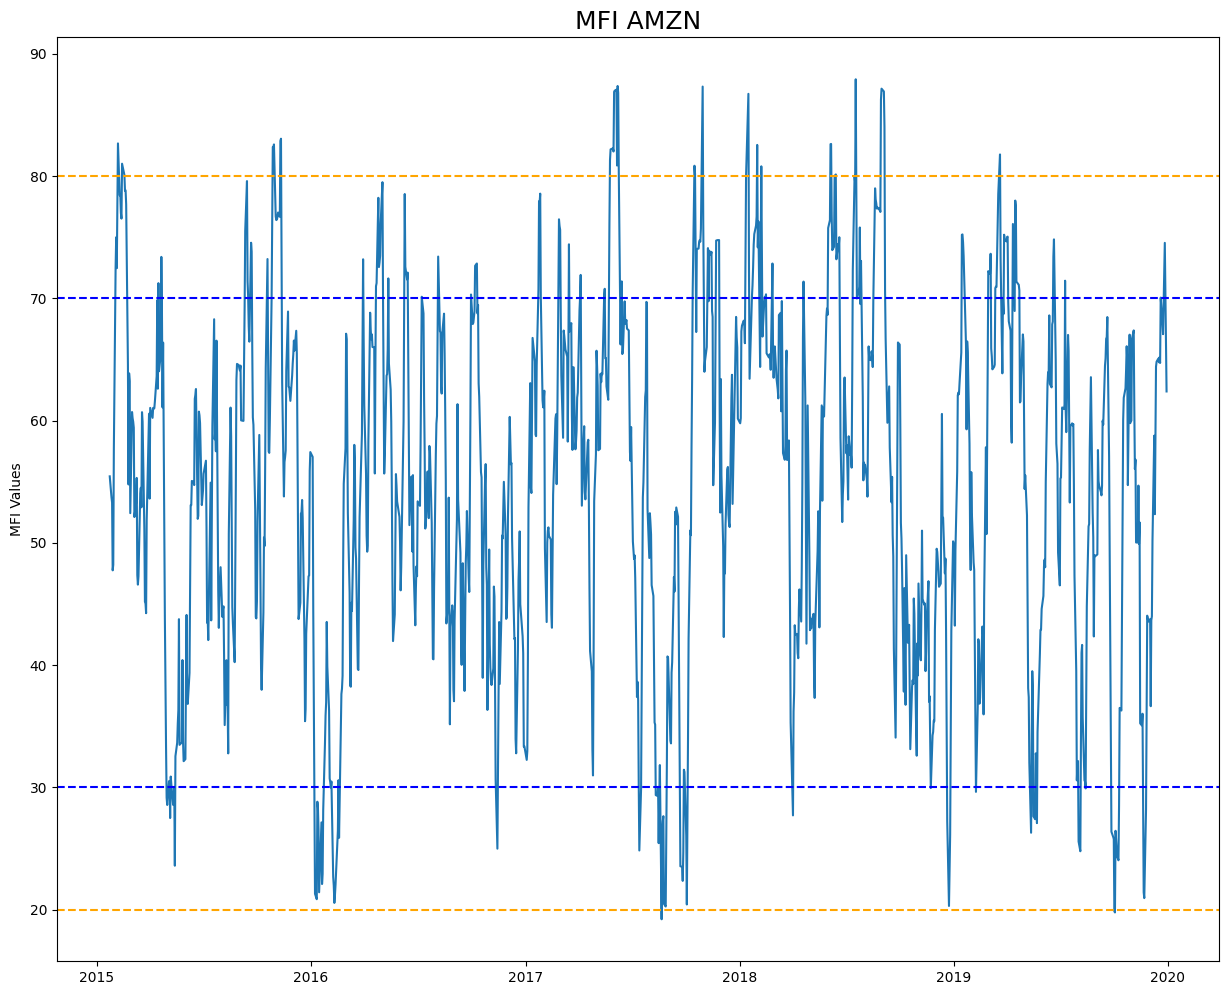

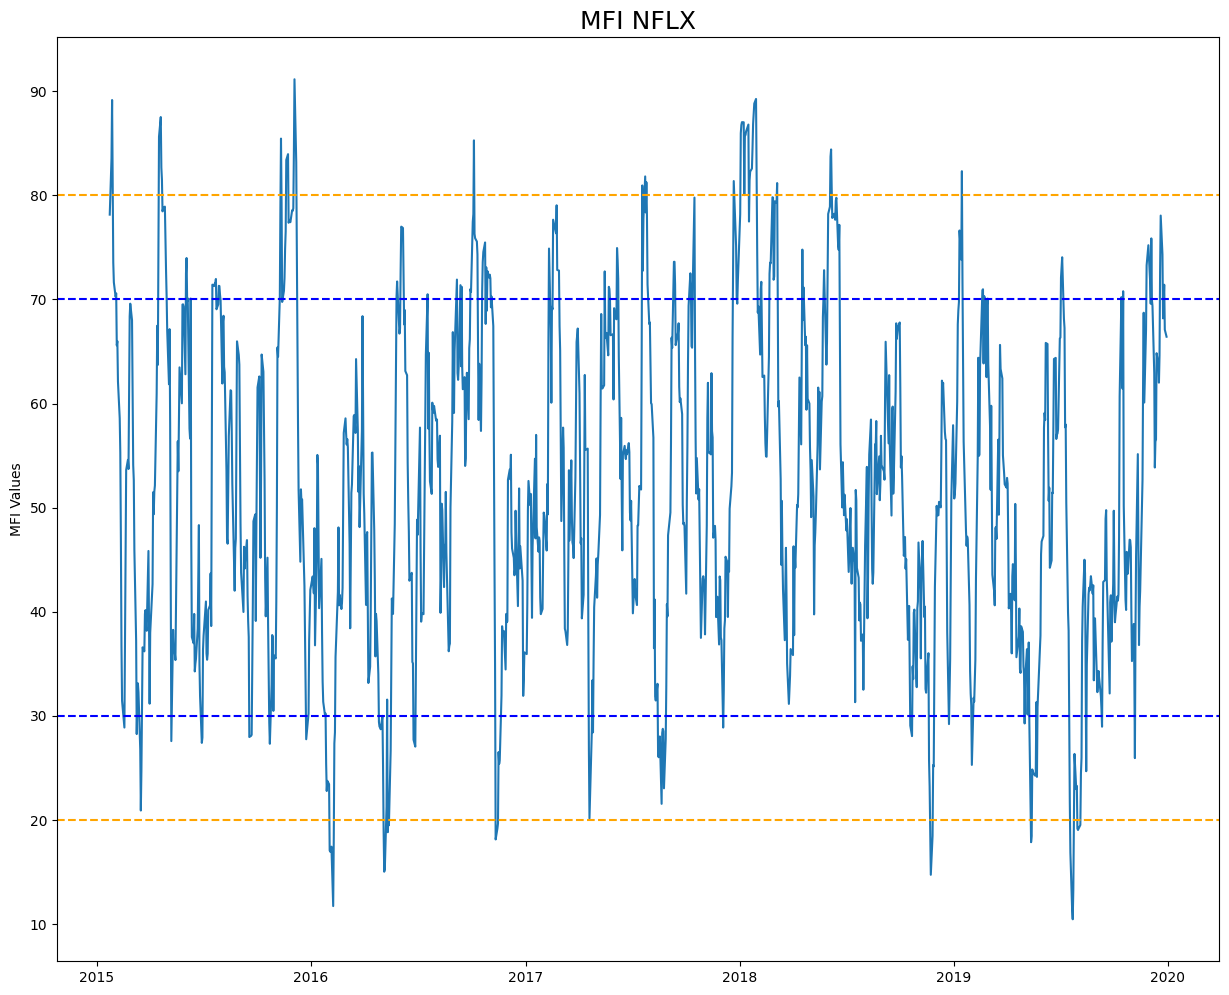

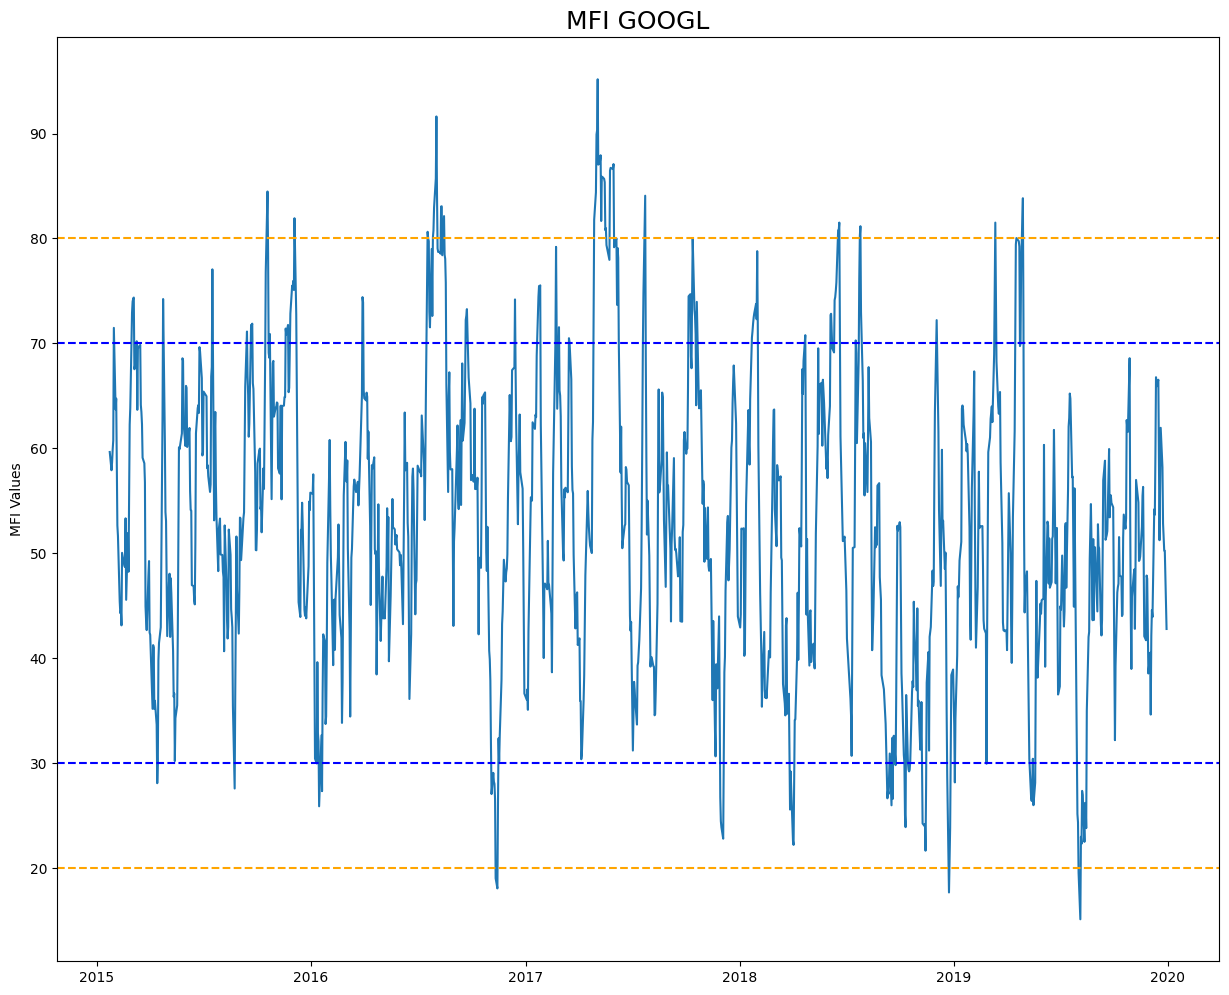

In [ ]:
# plotting MFI plot
for stock_name, df in stock_name_and_df:
    plt.figure(figsize=(15,12))
    plt.plot(df['MFI'], label=f'MFI')
    plt.axhline(20, linestyle= '--', color='orange')
    plt.axhline(30, linestyle= '--', color='blue')
    plt.axhline(70, linestyle= '--', color='blue')
    plt.axhline(80, linestyle= '--', color='orange')
    plt.title(f'MFI {stock_name}', fontsize=18)
    plt.ylabel('MFI Values')
    plt.show()

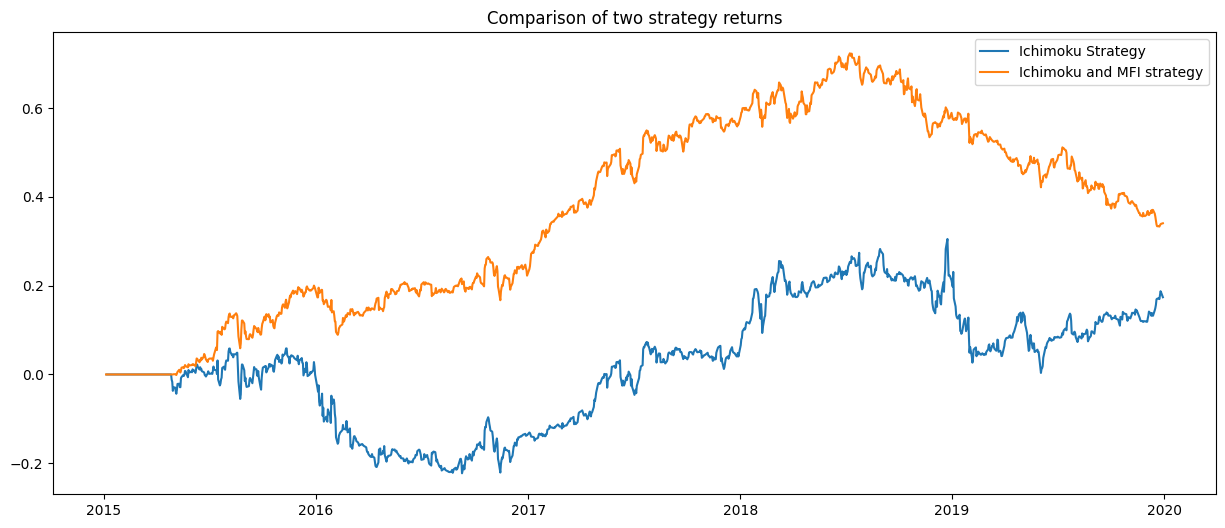

In [ ]:
# comparision of two strategy return
ichimoku_portfolio_only_returns
ichimoku_returns = ichimoku_portfolio_only_returns.apply(np.log1p).cumsum()
ichimoku_mfi_returns = ichimoku_and_mfi_portfolio_returns.apply(np.log1p).cumsum()
plt.figure(figsize = (15,6))
plt.plot(ichimoku_returns, label = "Ichimoku Strategy")
plt.plot(ichimoku_mfi_returns, label = "Ichimoku and MFI strategy")
plt.title("Comparison of two strategy returns")
plt.legend()
plt.show()
# .plot(figsize=(15,6), title = f"Portfolio Returns (Ichimoku + MFI)")

In [ ]:
daily_ichimoku_ret = ichimoku_portfolio_only_returns.apply(np.log1p).mean()
daily_ichimoku_mfi_ret = ichimoku_and_mfi_portfolio_returns.apply(np.log1p).mean()
annual_ichimoku_ret = daily_ichimoku_ret * 252
annual_ichimoku_mfi_ret = daily_ichimoku_mfi_ret * 252
annual_regular_ichimoku_ret = np.exp(annual_ichimoku_ret)-1
annual_regular_ichimoku_mfi_ret = np.exp(annual_ichimoku_mfi_ret)-1
print(f"Annual Ichimoku return: {annual_regular_ichimoku_ret}\n Annual Ichimoku MFI return: {annual_regular_ichimoku_mfi_ret}")
annual_ichimoku_ret_std = ichimoku_portfolio_only_returns.std() * (252 ** 0.5)
annual_ichimoku_mfi_ret_std = ichimoku_and_mfi_portfolio_returns.std() * (252 ** 0.5)
print(f"Annual Ichimoku standard deviation : {annual_ichimoku_ret_std}\n Annual Ichimoku MFI standard deviation: {annual_ichimoku_mfi_ret_std}")

ichimoku_sr = annual_regular_ichimoku_ret/ annual_ichimoku_ret_std
ichimoku_mfi_sr = annual_regular_ichimoku_mfi_ret/annual_ichimoku_mfi_ret_std
print(f"Ichimoku sharpe ratio: {ichimoku_sr} \n Ichimoku MFI sharpe ratio: {ichimoku_mfi_sr}")


Annual Ichimoku return: 0.035529732985750906
 Annual Ichimoku MFI return: 0.07067702464182934
Annual Ichimoku standard deviation : 0.1733179768134957
 Annual Ichimoku MFI standard deviation: 0.13663363075435447
Ichimoku sharpe ratio: 0.20499739057064922 
 Ichimoku MFI sharpe ratio: 0.5172739994657347


## This is to calculate the returns for a buy hold strategy

In [ ]:
meta_ret = stock_name_and_df[0][1]
appl_ret = stock_name_and_df[1][1]
amzn_ret = stock_name_and_df[2][1]
nflx_ret = stock_name_and_df[3][1]
googl_ret = stock_name_and_df[4][1]
# sum regular returns and divide by 5
buy_hold_stock_return = (meta_ret["Stock Returns"] + appl_ret["Stock Returns"] + amzn_ret["Stock Returns"] + nflx_ret["Stock Returns"] + googl_ret["Stock Returns"])/5
# convert to log returns
daily_buy_hold_stock_return = buy_hold_stock_return.apply(np.log1p).mean()
# get annual log returns
annual_buy_hold_stock_return = daily_buy_hold_stock_return * 252
# get annual regular returns
annual_regular_buy_hold_stock_return  = np.exp(annual_buy_hold_stock_return) - 1
print(f"Annual Buy hold stock returns {annual_regular_buy_hold_stock_return}")
# get regular standard deviation
annual_buy_hold_stock_return_std = buy_hold_stock_return.std() * (252 ** 0.5)
print(f"Annual Buy hold stock returns standard deviation {annual_buy_hold_stock_return_std}")
# get sharpe ratio
sr = annual_regular_buy_hold_stock_return / annual_buy_hold_stock_return_std
print(f"Stocks sharpe ratio {sr}")

Annual Buy hold stock returns 0.3247481006016657
Annual Buy hold stock returns standard deviation 0.22824056738992238
Stocks sharpe ratio 1.422832515338395
